In [1]:
!nvidia-smi

Wed Feb 28 10:54:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   29C    P8              20W / 215W |    502MiB /  8192MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [10]:
data_dir = '../data/data_preprocessed/crema_d/features/'

In [11]:
data_y = np.load(f'{data_dir}crema_d.label_emotion_key.npy', allow_pickle=True)
np.unique(data_y)

array(['ang', 'dis', 'fea', 'hap', 'neu', 'sad'], dtype=object)

In [12]:
len(data_y)

7442

In [13]:
data_x = np.load(f'{data_dir}crema_d.feature.mfcc128.npy', allow_pickle=True)
len(data_x)

7442

In [14]:
labels = ['ang', 'neu', 'sad', 'hap']

def label_filter(label):
    return label in labels

def label_to_index(label):
    return labels.index(label)
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(w) for w in data_y[filtered_idx]]
print(data_x.shape)

(4900,)


In [15]:
data_y[:10]

[2, 3, 3, 2, 3, 3, 3, 2, 0, 0]

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3920
Test: 980


In [17]:
x_train[0].shape

(128, 73)

In [18]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [19]:
def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for mfcc, label in batch:
        tensors += [torch.tensor(
            np.array(mfcc[:40], dtype=float), 
            dtype=torch.float32)]
        targets += [torch.tensor(label, 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [20]:
from omegaconf import OmegaConf as ocf
import traceback

In [21]:
from IConNet.nn.model import M18mfcc as M18

In [22]:
model_config_path = 'config/model/m18.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M18(config=model_config,
           n_input=40, 
            n_output=len(labels))
model

{'name': 'M18', 'description': 'FirConv sequential for speech emotion', 'fe': {'n_block': 2, 'n_channel': [129, 30], 'kernel_size': [127, 63], 'stride': [2, 8], 'window_k': [5, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 32, 'out_seq_length': 8, 'use_context': True, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm', 'dropout': 0.1}}


M18mfcc(
  (seq_blocks): Seq2MBlocks(
    (blocks): LSTM(40, 32, batch_first=True)
    (pad_layer): PadForConv()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((928,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=928, out_features=512, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=512, out_features=4, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [23]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [24]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [25]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                  | 0.006535947712418301/10 [00:00<13:12, 79.26s/it]

Train Epoch: 1 [0/3920 (0%)]	Loss: 1.356371
Mem before-during-after: 3012096 13808640 29934080


  1%|▍                                  | 0.13725490196078433/10 [00:07<08:07, 49.39s/it]

Train Epoch: 1 [640/3920 (16%)]	Loss: 1.087950
Mem before-during-after: 29934080 32334336 29934080


  3%|▉                                   | 0.2679738562091499/10 [00:13<07:42, 47.53s/it]

Train Epoch: 1 [1280/3920 (33%)]	Loss: 0.884817
Mem before-during-after: 29934080 32909312 29934080


  4%|█▍                                  | 0.3986928104575154/10 [00:19<07:51, 49.08s/it]

Train Epoch: 1 [1920/3920 (49%)]	Loss: 0.797181
Mem before-during-after: 29934080 31943680 29934080


  5%|█▉                                   | 0.529411764705881/10 [00:26<07:42, 48.79s/it]

Train Epoch: 1 [2560/3920 (65%)]	Loss: 0.845710
Mem before-during-after: 29934080 32501760 29934080


  7%|██▍                                 | 0.6601307189542466/10 [00:33<07:46, 49.95s/it]

Train Epoch: 1 [3200/3920 (82%)]	Loss: 1.058498
Mem before-during-after: 29934080 32574464 29934080


  8%|██▊                                 | 0.7908496732026121/10 [00:39<08:32, 55.71s/it]

Train Epoch: 1 [3840/3920 (98%)]	Loss: 0.905344
Mem before-during-after: 29934080 32431616 29934080


 10%|███▌                                | 1.0032679738562063/10 [00:50<07:28, 49.87s/it]


Test Epoch: 1	Accuracy: 600/976 (61%)

Train Epoch: 2 [0/3920 (0%)]	Loss: 0.853371
Mem before-during-after: 29933056 31751680 29934080


 11%|████▏                                | 1.137254901960781/10 [00:57<07:57, 53.87s/it]

Train Epoch: 2 [640/3920 (16%)]	Loss: 0.484424
Mem before-during-after: 29934080 31825408 29934080


 13%|████▌                               | 1.2679738562091465/10 [01:04<07:12, 49.48s/it]

Train Epoch: 2 [1280/3920 (33%)]	Loss: 1.115250
Mem before-during-after: 29934080 32814592 29934080


 14%|█████▏                               | 1.398692810457512/10 [01:10<07:13, 50.41s/it]

Train Epoch: 2 [1920/3920 (49%)]	Loss: 1.356517
Mem before-during-after: 29934080 32850944 29934080


 15%|█████▌                              | 1.5294117647058776/10 [01:17<07:17, 51.70s/it]

Train Epoch: 2 [2560/3920 (65%)]	Loss: 0.897382
Mem before-during-after: 29934080 32431616 29934080


 17%|█████▉                              | 1.6601307189542431/10 [01:23<06:58, 50.24s/it]

Train Epoch: 2 [3200/3920 (82%)]	Loss: 1.023800
Mem before-during-after: 29934080 31795712 29934080


 18%|██████▍                             | 1.7908496732026087/10 [01:30<06:52, 50.29s/it]

Train Epoch: 2 [3840/3920 (98%)]	Loss: 0.878798
Mem before-during-after: 29934080 32501760 29934080


 20%|███████▍                             | 2.003267973856203/10 [01:41<06:41, 50.24s/it]


Test Epoch: 2	Accuracy: 553/976 (56%)

Train Epoch: 3 [0/3920 (0%)]	Loss: 1.207296
Mem before-during-after: 29933056 32741888 29934080


 21%|███████▋                            | 2.1372549019607776/10 [01:48<06:39, 50.83s/it]

Train Epoch: 3 [640/3920 (16%)]	Loss: 0.748652
Mem before-during-after: 29934080 32401920 29934080


 23%|████████▍                            | 2.267973856209143/10 [01:54<06:23, 49.57s/it]

Train Epoch: 3 [1280/3920 (33%)]	Loss: 0.794429
Mem before-during-after: 29934080 32850944 29934080


 24%|████████▋                           | 2.3986928104575087/10 [02:01<06:43, 53.05s/it]

Train Epoch: 3 [1920/3920 (49%)]	Loss: 0.727304
Mem before-during-after: 29934080 32429056 29934080


 25%|█████████                           | 2.5294117647058743/10 [02:08<06:22, 51.19s/it]

Train Epoch: 3 [2560/3920 (65%)]	Loss: 1.146340
Mem before-during-after: 29934080 31840256 29934080


 27%|██████████                            | 2.66013071895424/10 [02:14<06:12, 50.71s/it]

Train Epoch: 3 [3200/3920 (82%)]	Loss: 0.983358
Mem before-during-after: 29934080 31869952 29934080


 28%|██████████                          | 2.7908496732026054/10 [02:21<06:13, 51.77s/it]

Train Epoch: 3 [3840/3920 (98%)]	Loss: 0.877807
Mem before-during-after: 29934080 32850944 29934080


 30%|██████████▊                         | 3.0032679738561994/10 [02:32<05:48, 49.87s/it]


Test Epoch: 3	Accuracy: 616/976 (63%)

Train Epoch: 4 [0/3920 (0%)]	Loss: 0.761458
Mem before-during-after: 29933056 31943680 29934080


 31%|███████████▌                         | 3.137254901960774/10 [02:38<05:53, 51.46s/it]

Train Epoch: 4 [640/3920 (16%)]	Loss: 0.622572
Mem before-during-after: 29934080 32403456 29934080


 33%|███████████▊                        | 3.2679738562091396/10 [02:45<05:42, 50.84s/it]

Train Epoch: 4 [1280/3920 (33%)]	Loss: 0.684319
Mem before-during-after: 29934080 31869952 29934080


 34%|████████████▌                        | 3.398692810457505/10 [02:52<05:33, 50.45s/it]

Train Epoch: 4 [1920/3920 (49%)]	Loss: 0.580651
Mem before-during-after: 29934080 32298496 29934080


 35%|████████████▋                       | 3.5294117647058707/10 [02:58<05:23, 49.97s/it]

Train Epoch: 4 [2560/3920 (65%)]	Loss: 1.004115
Mem before-during-after: 29934080 31795712 29934080


 37%|█████████████▏                      | 3.6601307189542363/10 [03:05<05:07, 48.53s/it]

Train Epoch: 4 [3200/3920 (82%)]	Loss: 0.973639
Mem before-during-after: 29934080 32334336 29934080


 38%|██████████████                       | 3.790849673202602/10 [03:11<05:06, 49.33s/it]

Train Epoch: 4 [3840/3920 (98%)]	Loss: 0.885466
Mem before-during-after: 29934080 31928832 29934080


 40%|██████████████▊                      | 4.003267973856196/10 [03:21<04:58, 49.81s/it]


Test Epoch: 4	Accuracy: 648/976 (66%)

Train Epoch: 5 [0/3920 (0%)]	Loss: 0.463633
Mem before-during-after: 29933056 32778240 29934080


 41%|██████████████▉                     | 4.1372549019607705/10 [03:28<04:50, 49.54s/it]

Train Epoch: 5 [640/3920 (16%)]	Loss: 0.776779
Mem before-during-after: 29934080 32370688 29934080


 43%|███████████████▊                     | 4.267973856209136/10 [03:35<04:54, 51.36s/it]

Train Epoch: 5 [1280/3920 (33%)]	Loss: 0.609261
Mem before-during-after: 29934080 31840256 29934080


 44%|████████████████▎                    | 4.398692810457502/10 [03:41<04:36, 49.38s/it]

Train Epoch: 5 [1920/3920 (49%)]	Loss: 0.876991
Mem before-during-after: 29934080 32501760 29934080


 45%|████████████████▊                    | 4.529411764705867/10 [03:48<04:30, 49.42s/it]

Train Epoch: 5 [2560/3920 (65%)]	Loss: 0.555682
Mem before-during-after: 29934080 32741888 29934080


 47%|█████████████████▏                   | 4.660130718954233/10 [03:54<04:34, 51.41s/it]

Train Epoch: 5 [3200/3920 (82%)]	Loss: 0.912332
Mem before-during-after: 29934080 31840256 29934080


 48%|█████████████████▋                   | 4.790849673202598/10 [04:01<04:13, 48.58s/it]

Train Epoch: 5 [3840/3920 (98%)]	Loss: 0.939939
Mem before-during-after: 29934080 31958528 29934080


 50%|██████████████████▌                  | 5.003267973856192/10 [04:11<04:07, 49.50s/it]


Test Epoch: 5	Accuracy: 627/976 (64%)

Train Epoch: 6 [0/3920 (0%)]	Loss: 0.674247
Mem before-during-after: 29933056 32370688 29934080


 51%|███████████████████                  | 5.137254901960767/10 [04:18<03:57, 48.84s/it]

Train Epoch: 6 [640/3920 (16%)]	Loss: 1.050020
Mem before-during-after: 29934080 31869952 29934080


 53%|██████████████████▉                 | 5.2679738562091325/10 [04:24<03:54, 49.50s/it]

Train Epoch: 6 [1280/3920 (33%)]	Loss: 1.129215
Mem before-during-after: 29934080 32814592 29934080


 54%|███████████████████▉                 | 5.398692810457498/10 [04:31<03:58, 51.78s/it]

Train Epoch: 6 [1920/3920 (49%)]	Loss: 0.963249
Mem before-during-after: 29934080 32945664 29934080


 55%|████████████████████▍                | 5.529411764705864/10 [04:37<03:44, 50.25s/it]

Train Epoch: 6 [2560/3920 (65%)]	Loss: 0.716526
Mem before-during-after: 29934080 31943680 29934080


 57%|████████████████████▉                | 5.660130718954229/10 [04:44<03:35, 49.64s/it]

Train Epoch: 6 [3200/3920 (82%)]	Loss: 0.827559
Mem before-during-after: 29934080 31840256 29934080


 58%|█████████████████████▍               | 5.790849673202595/10 [04:50<03:25, 48.75s/it]

Train Epoch: 6 [3840/3920 (98%)]	Loss: 1.031942
Mem before-during-after: 29934080 32574464 29934080


 60%|██████████████████████▏              | 6.003267973856189/10 [05:00<03:17, 49.40s/it]


Test Epoch: 6	Accuracy: 609/976 (62%)

Train Epoch: 7 [0/3920 (0%)]	Loss: 0.692367
Mem before-during-after: 29933056 32741888 29934080


 61%|██████████████████████▋              | 6.137254901960763/10 [05:07<03:08, 48.89s/it]

Train Epoch: 7 [640/3920 (16%)]	Loss: 0.954401
Mem before-during-after: 29934080 32370688 29934080


 63%|███████████████████████▏             | 6.267973856209129/10 [05:13<03:05, 49.68s/it]

Train Epoch: 7 [1280/3920 (33%)]	Loss: 1.064946
Mem before-during-after: 29934080 32501760 29934080


 64%|███████████████████████             | 6.3986928104574945/10 [05:20<03:00, 50.02s/it]

Train Epoch: 7 [1920/3920 (49%)]	Loss: 1.025882
Mem before-during-after: 29934080 31943680 29934080


 65%|████████████████████████▊             | 6.52941176470586/10 [05:27<02:56, 50.81s/it]

Train Epoch: 7 [2560/3920 (65%)]	Loss: 0.618790
Mem before-during-after: 29934080 32403456 29934080


 67%|████████████████████████▋            | 6.660130718954226/10 [05:33<02:50, 51.11s/it]

Train Epoch: 7 [3200/3920 (82%)]	Loss: 1.147385
Mem before-during-after: 29934080 32538112 29934080


 68%|█████████████████████████▏           | 6.790849673202591/10 [05:40<02:42, 50.75s/it]

Train Epoch: 7 [3840/3920 (98%)]	Loss: 0.585485
Mem before-during-after: 29934080 31928832 29934080


 70%|█████████████████████████▉           | 7.003267973856185/10 [05:50<02:27, 49.36s/it]


Test Epoch: 7	Accuracy: 643/976 (66%)

Train Epoch: 8 [0/3920 (0%)]	Loss: 1.179571
Mem before-during-after: 29933056 31958528 29934080


 71%|███████████████████████████           | 7.13725490196076/10 [05:57<02:24, 50.57s/it]

Train Epoch: 8 [640/3920 (16%)]	Loss: 0.307908
Mem before-during-after: 29934080 32538112 29934080


 73%|██████████████████████████▉          | 7.267973856209125/10 [06:04<02:14, 49.36s/it]

Train Epoch: 8 [1280/3920 (33%)]	Loss: 0.314758
Mem before-during-after: 29934080 32328192 29934080


 74%|███████████████████████████▍         | 7.398692810457491/10 [06:10<02:10, 50.20s/it]

Train Epoch: 8 [1920/3920 (49%)]	Loss: 0.785762
Mem before-during-after: 29934080 31825408 29934080


 75%|███████████████████████████         | 7.5294117647058565/10 [06:17<02:05, 50.65s/it]

Train Epoch: 8 [2560/3920 (65%)]	Loss: 0.752133
Mem before-during-after: 29934080 32778240 29934080


 77%|████████████████████████████▎        | 7.660130718954222/10 [06:23<01:58, 50.61s/it]

Train Epoch: 8 [3200/3920 (82%)]	Loss: 1.319882
Mem before-during-after: 29934080 32465408 29934080


 78%|████████████████████████████▊        | 7.790849673202588/10 [06:30<01:49, 49.43s/it]

Train Epoch: 8 [3840/3920 (98%)]	Loss: 0.624973
Mem before-during-after: 29934080 32850944 29934080


 80%|█████████████████████████████▌       | 8.003267973856182/10 [06:41<01:38, 49.30s/it]


Test Epoch: 8	Accuracy: 628/976 (64%)

Train Epoch: 9 [0/3920 (0%)]	Loss: 0.886903
Mem before-during-after: 29933056 31825408 29934080


 81%|██████████████████████████████       | 8.137254901960757/10 [06:47<01:35, 51.13s/it]

Train Epoch: 9 [640/3920 (16%)]	Loss: 0.574523
Mem before-during-after: 29934080 32778240 29934080


 83%|██████████████████████████████▌      | 8.267973856209123/10 [06:54<01:30, 52.00s/it]

Train Epoch: 9 [1280/3920 (33%)]	Loss: 0.467975
Mem before-during-after: 29934080 32343040 29934080


 84%|███████████████████████████████      | 8.398692810457488/10 [07:01<01:21, 50.82s/it]

Train Epoch: 9 [1920/3920 (49%)]	Loss: 0.808118
Mem before-during-after: 29934080 32909312 29934080


 85%|███████████████████████████████▌     | 8.529411764705854/10 [07:08<01:15, 51.21s/it]

Train Epoch: 9 [2560/3920 (65%)]	Loss: 0.600988
Mem before-during-after: 29934080 32501760 29934080


 87%|████████████████████████████████▉     | 8.66013071895422/10 [07:14<01:07, 50.09s/it]

Train Epoch: 9 [3200/3920 (82%)]	Loss: 1.204937
Mem before-during-after: 29934080 31913984 29934080


 88%|████████████████████████████████▌    | 8.790849673202585/10 [07:21<01:02, 51.41s/it]

Train Epoch: 9 [3840/3920 (98%)]	Loss: 0.225285
Mem before-during-after: 29934080 32501760 29934080


 90%|█████████████████████████████████▎   | 9.003267973856179/10 [07:31<00:49, 49.48s/it]


Test Epoch: 9	Accuracy: 657/976 (67%)

Train Epoch: 10 [0/3920 (0%)]	Loss: 0.989845
Mem before-during-after: 29933056 31840256 29934080


 91%|█████████████████████████████████▊   | 9.137254901960754/10 [07:38<00:42, 49.10s/it]

Train Epoch: 10 [640/3920 (16%)]	Loss: 0.475281
Mem before-during-after: 29934080 32501760 29934080


 93%|███████████████████████████████████▏  | 9.26797385620912/10 [07:45<00:37, 51.04s/it]

Train Epoch: 10 [1280/3920 (33%)]	Loss: 0.490100
Mem before-during-after: 29934080 32099840 29934080


 94%|██████████████████████████████████▊  | 9.398692810457485/10 [07:51<00:30, 50.61s/it]

Train Epoch: 10 [1920/3920 (49%)]	Loss: 0.895987
Mem before-during-after: 29934080 32429056 29934080


 95%|████████████████████████████████████▏ | 9.52941176470585/10 [07:58<00:22, 48.22s/it]

Train Epoch: 10 [2560/3920 (65%)]	Loss: 0.689544
Mem before-during-after: 29934080 32778240 29934080


 97%|███████████████████████████████████▋ | 9.660130718954216/10 [08:04<00:17, 51.06s/it]

Train Epoch: 10 [3200/3920 (82%)]	Loss: 0.825402
Mem before-during-after: 29934080 32538112 29934080


 98%|████████████████████████████████████▏| 9.790849673202581/10 [08:11<00:10, 50.00s/it]

Train Epoch: 10 [3840/3920 (98%)]	Loss: 0.820970
Mem before-during-after: 29934080 31869952 29934080


100%|████████████████████████████████████▉| 9.999999999999966/10 [08:21<00:00, 50.19s/it]


Test Epoch: 10	Accuracy: 635/976 (65%)



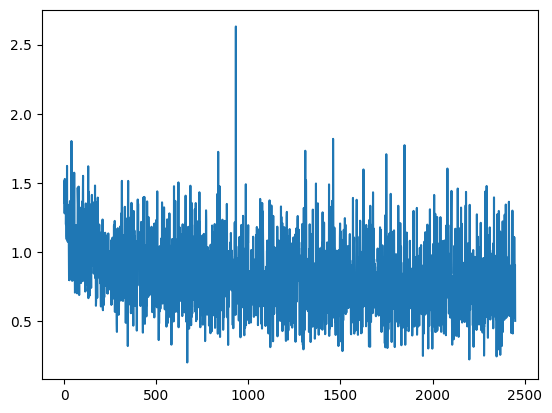

In [26]:
plt.plot(train_losses)

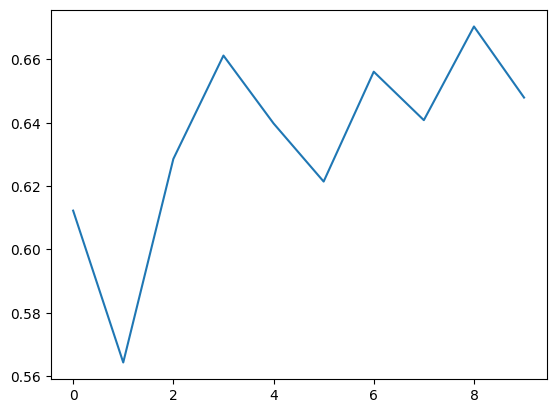

In [27]:
plt.plot(test_accuracy)

In [28]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [29]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 635/976 (0.6506)
{'acc_detail': tensor([0.8103, 0.7742, 0.5984, 0.4365], device='cuda:0'),
 'acc_unweighted': tensor(0.6549, device='cuda:0'),
 'acc_weighted': tensor(0.6506, device='cuda:0'),
 'f1s_detail': tensor([0.7428, 0.6234, 0.6831, 0.5288], device='cuda:0'),
 'f1s_unweighted': tensor(0.6445, device='cuda:0'),
 'f1s_weighted': tensor(0.6455, device='cuda:0'),
 'precision_detail': tensor([0.6856, 0.5217, 0.7958, 0.6707], device='cuda:0'),
 'recall_detail': tensor([0.8103, 0.7742, 0.5984, 0.4365], device='cuda:0'),
 'rocauc': tensor(0.8885, device='cuda:0'),
 'rocauc_detail': tensor([0.9318, 0.8703, 0.9224, 0.8294], device='cuda:0'),
 'uar': tensor(0.6549, device='cuda:0'),
 'wap': tensor(0.6740, device='cuda:0')}


tensor([[205,  12,   1,  35],
        [ 14, 168,  28,   7],
        [  8,  82, 152,  12],
        [ 72,  60,  10, 110]], device='cuda:0')

In [31]:
model_path = '../models_cremad4/cremad_label4_m18mfcc40_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [32]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m18mfcc40_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                  | 0.006535947712418301/50 [00:00<45:38, 54.77s/it]

Train Epoch: 11 [0/3920 (0%)]	Loss: 0.702449
Mem before-during-after: 23188480 25829888 29213696


  0%|                                   | 0.13725490196078433/50 [00:07<46:40, 56.16s/it]

Train Epoch: 11 [640/3920 (16%)]	Loss: 0.612891
Mem before-during-after: 29213696 31622656 29213696


  1%|▏                                   | 0.2679738562091499/50 [00:15<46:59, 56.70s/it]

Train Epoch: 11 [1280/3920 (33%)]	Loss: 0.926726
Mem before-during-after: 29213696 31031296 29213696


  1%|▎                                   | 0.3986928104575154/50 [00:22<48:48, 59.05s/it]

Train Epoch: 11 [1920/3920 (49%)]	Loss: 0.499665
Mem before-during-after: 29213696 31105024 29213696


  1%|▍                                    | 0.529411764705881/50 [00:29<46:28, 56.36s/it]

Train Epoch: 11 [2560/3920 (65%)]	Loss: 0.467349
Mem before-during-after: 29213696 31238144 29213696


  1%|▍                                   | 0.6601307189542466/50 [00:37<46:50, 56.97s/it]

Train Epoch: 11 [3200/3920 (82%)]	Loss: 0.496652
Mem before-during-after: 29213696 32188928 29213696


  2%|▌                                    | 0.787581699346403/50 [00:44<45:39, 55.67s/it]

Train Epoch: 11 [3840/3920 (98%)]	Loss: 0.623106
Mem before-during-after: 29213696 32225280 29213696


  2%|▋                                   | 1.0032679738562063/50 [00:56<45:31, 55.74s/it]


Test Epoch: 11	Accuracy: 670/976 (68%)

saved model: ../models_cremad4/cremad_label4_m18mfcc40_best_11epoch.pt
Train Epoch: 12 [0/3920 (0%)]	Loss: 0.699302
Mem before-during-after: 29212672 32130560 29213696


  2%|▊                                    | 1.137254901960781/50 [01:04<45:28, 55.85s/it]

Train Epoch: 12 [640/3920 (16%)]	Loss: 0.571005
Mem before-during-after: 29213696 31119872 29213696


  3%|▉                                   | 1.2679738562091465/50 [01:11<45:06, 55.54s/it]

Train Epoch: 12 [1280/3920 (33%)]	Loss: 0.712379
Mem before-during-after: 29213696 31238144 29213696


  3%|█                                    | 1.398692810457512/50 [01:19<46:00, 56.81s/it]

Train Epoch: 12 [1920/3920 (49%)]	Loss: 0.556812
Mem before-during-after: 29213696 31948800 29213696


  3%|█                                   | 1.5294117647058776/50 [01:26<44:36, 55.22s/it]

Train Epoch: 12 [2560/3920 (65%)]	Loss: 0.641679
Mem before-during-after: 29213696 32474112 29213696


  3%|█▏                                  | 1.6601307189542431/50 [01:33<45:44, 56.78s/it]

Train Epoch: 12 [3200/3920 (82%)]	Loss: 0.646965
Mem before-during-after: 29213696 31149568 29213696


  4%|█▎                                  | 1.7908496732026087/50 [01:41<45:53, 57.12s/it]

Train Epoch: 12 [3840/3920 (98%)]	Loss: 0.307534
Mem before-during-after: 29213696 32021504 29213696


  4%|█▍                                   | 2.003267973856203/50 [01:53<45:08, 56.43s/it]


Test Epoch: 12	Accuracy: 665/976 (68%)

Train Epoch: 13 [0/3920 (0%)]	Loss: 0.397156
Mem before-during-after: 29212672 32130560 29213696


  4%|█▌                                  | 2.1372549019607776/50 [02:00<45:49, 57.44s/it]

Train Epoch: 13 [640/3920 (16%)]	Loss: 0.588573
Mem before-during-after: 29213696 31613952 29213696


  5%|█▋                                   | 2.267973856209143/50 [02:08<44:56, 56.49s/it]

Train Epoch: 13 [1280/3920 (33%)]	Loss: 0.671344
Mem before-during-after: 29213696 31948800 29213696


  5%|█▋                                  | 2.3986928104575087/50 [02:15<44:36, 56.23s/it]

Train Epoch: 13 [1920/3920 (49%)]	Loss: 0.652140
Mem before-during-after: 29213696 31483392 29213696


  5%|█▊                                  | 2.5294117647058743/50 [02:22<43:37, 55.13s/it]

Train Epoch: 13 [2560/3920 (65%)]	Loss: 0.572023
Mem before-during-after: 29213696 32225280 29213696


  5%|██                                    | 2.66013071895424/50 [02:30<44:29, 56.40s/it]

Train Epoch: 13 [3200/3920 (82%)]	Loss: 0.923286
Mem before-during-after: 29213696 31890432 29213696


  6%|██                                  | 2.7908496732026054/50 [02:37<43:02, 54.70s/it]

Train Epoch: 13 [3840/3920 (98%)]	Loss: 0.609164
Mem before-during-after: 29213696 31149568 29213696


  6%|██▏                                 | 2.9999999999999902/50 [02:48<42:28, 54.23s/it]


Test Epoch: 13	Accuracy: 669/976 (68%)



  6%|██▏                                 | 3.0065359477124085/50 [02:49<46:02, 58.77s/it]

Train Epoch: 14 [0/3920 (0%)]	Loss: 0.401270
Mem before-during-after: 29212672 31817728 29213696


  6%|██▎                                  | 3.137254901960774/50 [02:56<44:47, 57.34s/it]

Train Epoch: 14 [640/3920 (16%)]	Loss: 0.683979
Mem before-during-after: 29213696 31134720 29213696


  7%|██▎                                 | 3.2647058823529305/50 [03:04<45:37, 58.57s/it]

Train Epoch: 14 [1280/3920 (33%)]	Loss: 0.433456
Mem before-during-after: 29213696 32057856 29213696


  7%|██▌                                  | 3.398692810457505/50 [03:12<44:31, 57.32s/it]

Train Epoch: 14 [1920/3920 (49%)]	Loss: 0.588656
Mem before-during-after: 29213696 31681536 29213696


  7%|██▌                                 | 3.5294117647058707/50 [03:19<43:27, 56.12s/it]

Train Epoch: 14 [2560/3920 (65%)]	Loss: 0.399085
Mem before-during-after: 29213696 31238144 29213696


  7%|██▋                                 | 3.6601307189542363/50 [03:26<43:42, 56.60s/it]

Train Epoch: 14 [3200/3920 (82%)]	Loss: 0.377575
Mem before-during-after: 29213696 31105024 29213696


  8%|██▊                                  | 3.790849673202602/50 [03:34<44:03, 57.21s/it]

Train Epoch: 14 [3840/3920 (98%)]	Loss: 0.376597
Mem before-during-after: 29213696 31947776 29213696


  8%|██▉                                 | 3.9999999999999867/50 [03:46<42:45, 55.78s/it]


Test Epoch: 14	Accuracy: 666/976 (68%)



  8%|██▉                                  | 4.006535947712405/50 [03:46<44:10, 57.63s/it]

Train Epoch: 15 [0/3920 (0%)]	Loss: 0.355377
Mem before-during-after: 29212672 31711232 29213696


  8%|██▉                                 | 4.1372549019607705/50 [03:53<43:06, 56.39s/it]

Train Epoch: 15 [640/3920 (16%)]	Loss: 0.993113
Mem before-during-after: 29213696 30859776 29213696


  9%|███▏                                 | 4.267973856209136/50 [04:01<42:57, 56.35s/it]

Train Epoch: 15 [1280/3920 (33%)]	Loss: 0.694460
Mem before-during-after: 29213696 31208448 29213696


  9%|███▎                                 | 4.398692810457502/50 [04:08<42:02, 55.31s/it]

Train Epoch: 15 [1920/3920 (49%)]	Loss: 0.486052
Mem before-during-after: 29213696 32066048 29213696


  9%|███▎                                 | 4.529411764705867/50 [04:16<43:07, 56.90s/it]

Train Epoch: 15 [2560/3920 (65%)]	Loss: 0.490935
Mem before-during-after: 29213696 31223296 29213696


  9%|███▍                                 | 4.660130718954233/50 [04:23<43:10, 57.15s/it]

Train Epoch: 15 [3200/3920 (82%)]	Loss: 0.645540
Mem before-during-after: 29213696 32130560 29213696


 10%|███▌                                 | 4.790849673202598/50 [04:30<41:59, 55.72s/it]

Train Epoch: 15 [3840/3920 (98%)]	Loss: 0.495844
Mem before-during-after: 29213696 32094208 29213696


 10%|███▋                                 | 5.003267973856192/50 [04:42<41:20, 55.12s/it]


Test Epoch: 15	Accuracy: 669/976 (68%)

Train Epoch: 16 [0/3920 (0%)]	Loss: 0.416493
Mem before-during-after: 29212672 31745024 29213696


 10%|███▊                                 | 5.137254901960767/50 [04:50<42:23, 56.70s/it]

Train Epoch: 16 [640/3920 (16%)]	Loss: 0.369198
Mem before-during-after: 29213696 31379456 29213696


 11%|███▊                                | 5.2679738562091325/50 [04:57<41:07, 55.15s/it]

Train Epoch: 16 [1280/3920 (33%)]	Loss: 0.487359
Mem before-during-after: 29213696 32021504 29213696


 11%|███▉                                 | 5.398692810457498/50 [05:04<42:16, 56.86s/it]

Train Epoch: 16 [1920/3920 (49%)]	Loss: 0.694872
Mem before-during-after: 29213696 31781376 29213696


 11%|████                                 | 5.529411764705864/50 [05:12<40:28, 54.61s/it]

Train Epoch: 16 [2560/3920 (65%)]	Loss: 0.350514
Mem before-during-after: 29213696 31223296 29213696


 11%|████▏                                | 5.660130718954229/50 [05:19<41:25, 56.05s/it]

Train Epoch: 16 [3200/3920 (82%)]	Loss: 0.687510
Mem before-during-after: 29213696 31223296 29213696


 12%|████▎                                | 5.790849673202595/50 [05:26<41:38, 56.51s/it]

Train Epoch: 16 [3840/3920 (98%)]	Loss: 0.690785
Mem before-during-after: 29213696 31149568 29213696


 12%|████▍                                | 6.003267973856189/50 [05:38<39:35, 54.00s/it]


Test Epoch: 16	Accuracy: 665/976 (68%)

Train Epoch: 17 [0/3920 (0%)]	Loss: 0.458260
Mem before-during-after: 29212672 31666688 29213696


 12%|████▌                                | 6.137254901960763/50 [05:45<43:40, 59.73s/it]

Train Epoch: 17 [640/3920 (16%)]	Loss: 0.614887
Mem before-during-after: 29213696 31223296 29213696


 13%|████▋                                | 6.267973856209129/50 [05:53<43:29, 59.67s/it]

Train Epoch: 17 [1280/3920 (33%)]	Loss: 0.533442
Mem before-during-after: 29213696 31829504 29213696


 13%|████▌                               | 6.3986928104574945/50 [06:00<40:35, 55.85s/it]

Train Epoch: 17 [1920/3920 (49%)]	Loss: 0.558081
Mem before-during-after: 29213696 31238144 29213696


 13%|████▉                                 | 6.52941176470586/50 [06:08<41:30, 57.29s/it]

Train Epoch: 17 [2560/3920 (65%)]	Loss: 0.194378
Mem before-during-after: 29213696 32130560 29213696


 13%|████▉                                | 6.660130718954226/50 [06:15<41:32, 57.50s/it]

Train Epoch: 17 [3200/3920 (82%)]	Loss: 0.763599
Mem before-during-after: 29213696 31666688 29213696


 14%|█████                                | 6.790849673202591/50 [06:23<40:21, 56.05s/it]

Train Epoch: 17 [3840/3920 (98%)]	Loss: 0.693210
Mem before-during-after: 29213696 32021504 29213696


 14%|█████▏                               | 7.003267973856185/50 [06:34<40:19, 56.27s/it]


Test Epoch: 17	Accuracy: 669/976 (68%)

Train Epoch: 18 [0/3920 (0%)]	Loss: 0.425411
Mem before-during-after: 29212672 31607808 29213696


 14%|█████▍                                | 7.13725490196076/50 [06:42<40:28, 56.66s/it]

Train Epoch: 18 [640/3920 (16%)]	Loss: 0.716416
Mem before-during-after: 29213696 31341568 29213696


 15%|█████▍                               | 7.267973856209125/50 [06:49<40:13, 56.47s/it]

Train Epoch: 18 [1280/3920 (33%)]	Loss: 0.621529
Mem before-during-after: 29213696 32057856 29213696


 15%|█████▍                               | 7.398692810457491/50 [06:56<38:22, 54.04s/it]

Train Epoch: 18 [1920/3920 (49%)]	Loss: 0.481804
Mem before-during-after: 29213696 31985152 29213696


 15%|█████▍                              | 7.5294117647058565/50 [07:04<42:03, 59.42s/it]

Train Epoch: 18 [2560/3920 (65%)]	Loss: 0.535479
Mem before-during-after: 29213696 31238144 29213696


 15%|█████▋                               | 7.660130718954222/50 [07:11<40:15, 57.04s/it]

Train Epoch: 18 [3200/3920 (82%)]	Loss: 0.446756
Mem before-during-after: 29213696 32057856 29213696


 16%|█████▊                               | 7.790849673202588/50 [07:18<40:02, 56.92s/it]

Train Epoch: 18 [3840/3920 (98%)]	Loss: 0.358103
Mem before-during-after: 29213696 31711232 29213696


 16%|█████▉                               | 8.003267973856182/50 [07:30<38:15, 54.67s/it]


Test Epoch: 18	Accuracy: 669/976 (68%)

Train Epoch: 19 [0/3920 (0%)]	Loss: 0.333505
Mem before-during-after: 29212672 31149568 29213696


 16%|██████                               | 8.137254901960757/50 [07:38<38:07, 54.65s/it]

Train Epoch: 19 [640/3920 (16%)]	Loss: 0.314225
Mem before-during-after: 29213696 32130560 29213696


 17%|██████                               | 8.267973856209123/50 [07:45<39:00, 56.07s/it]

Train Epoch: 19 [1280/3920 (33%)]	Loss: 0.481503
Mem before-during-after: 29213696 32225280 29213696


 17%|██████▏                              | 8.398692810457488/50 [07:53<38:38, 55.74s/it]

Train Epoch: 19 [1920/3920 (49%)]	Loss: 0.712566
Mem before-during-after: 29213696 31985152 29213696


 17%|██████▎                              | 8.529411764705854/50 [08:00<38:12, 55.29s/it]

Train Epoch: 19 [2560/3920 (65%)]	Loss: 0.736471
Mem before-during-after: 29213696 31105024 29213696


 17%|██████▌                               | 8.66013071895422/50 [08:07<37:44, 54.78s/it]

Train Epoch: 19 [3200/3920 (82%)]	Loss: 0.320400
Mem before-during-after: 29213696 31829504 29213696


 18%|██████▌                              | 8.790849673202585/50 [08:15<40:58, 59.66s/it]

Train Epoch: 19 [3840/3920 (98%)]	Loss: 0.491822
Mem before-during-after: 29213696 31223296 29213696


 18%|██████▋                              | 9.003267973856179/50 [08:26<37:42, 55.19s/it]


Test Epoch: 19	Accuracy: 673/976 (69%)

saved model: ../models_cremad4/cremad_label4_m18mfcc40_best_19epoch.pt
Train Epoch: 20 [0/3920 (0%)]	Loss: 0.659823
Mem before-during-after: 29212672 31740928 29213696


 18%|██████▊                              | 9.137254901960754/50 [08:34<37:58, 55.76s/it]

Train Epoch: 20 [640/3920 (16%)]	Loss: 0.698250
Mem before-during-after: 29213696 31119872 29213696


 19%|███████                               | 9.26797385620912/50 [08:41<39:13, 57.79s/it]

Train Epoch: 20 [1280/3920 (33%)]	Loss: 0.209818
Mem before-during-after: 29213696 31711232 29213696


 19%|██████▉                              | 9.398692810457485/50 [08:49<39:14, 57.99s/it]

Train Epoch: 20 [1920/3920 (49%)]	Loss: 0.321550
Mem before-during-after: 29213696 31829504 29213696


 19%|███████▏                              | 9.52941176470585/50 [08:56<37:41, 55.87s/it]

Train Epoch: 20 [2560/3920 (65%)]	Loss: 0.726005
Mem before-during-after: 29213696 32225280 29213696


 19%|███████▏                             | 9.660130718954216/50 [09:04<39:30, 58.77s/it]

Train Epoch: 20 [3200/3920 (82%)]	Loss: 0.612232
Mem before-during-after: 29213696 31134720 29213696


 20%|███████▏                             | 9.790849673202581/50 [09:11<38:03, 56.79s/it]

Train Epoch: 20 [3840/3920 (98%)]	Loss: 0.255342
Mem before-during-after: 29213696 32094208 29213696


 20%|███████▏                            | 10.003267973856175/50 [09:23<37:00, 55.53s/it]


Test Epoch: 20	Accuracy: 675/976 (69%)

saved model: ../models_cremad4/cremad_label4_m18mfcc40_best_20epoch.pt
Train Epoch: 21 [0/3920 (0%)]	Loss: 0.172371
Mem before-during-after: 29212672 30859776 29213696


 20%|███████▌                             | 10.13725490196075/50 [09:30<36:23, 54.76s/it]

Train Epoch: 21 [640/3920 (16%)]	Loss: 0.726112
Mem before-during-after: 29213696 30859776 29213696


 21%|███████▍                            | 10.267973856209116/50 [09:37<36:52, 55.68s/it]

Train Epoch: 21 [1280/3920 (33%)]	Loss: 0.547612
Mem before-during-after: 29213696 31119872 29213696


 21%|███████▍                            | 10.398692810457481/50 [09:45<36:54, 55.91s/it]

Train Epoch: 21 [1920/3920 (49%)]	Loss: 0.926344
Mem before-during-after: 29213696 31711232 29213696


 21%|███████▌                            | 10.529411764705847/50 [09:52<36:26, 55.40s/it]

Train Epoch: 21 [2560/3920 (65%)]	Loss: 0.435624
Mem before-during-after: 29213696 31238144 29213696


 21%|███████▋                            | 10.660130718954212/50 [09:59<37:13, 56.77s/it]

Train Epoch: 21 [3200/3920 (82%)]	Loss: 0.338039
Mem before-during-after: 29213696 32188928 29213696


 22%|███████▊                            | 10.790849673202578/50 [10:07<37:01, 56.66s/it]

Train Epoch: 21 [3840/3920 (98%)]	Loss: 0.242775
Mem before-during-after: 29213696 31193600 29213696


 22%|███████▉                            | 11.003267973856172/50 [10:18<36:42, 56.47s/it]


Test Epoch: 21	Accuracy: 683/976 (70%)

saved model: ../models_cremad4/cremad_label4_m18mfcc40_best_21epoch.pt
Train Epoch: 22 [0/3920 (0%)]	Loss: 0.241963
Mem before-during-after: 29212672 32021504 29213696


 22%|████████                            | 11.137254901960747/50 [10:26<35:09, 54.28s/it]

Train Epoch: 22 [640/3920 (16%)]	Loss: 0.228145
Mem before-during-after: 29213696 32021504 29213696


 23%|████████                            | 11.267973856209112/50 [10:33<35:28, 54.94s/it]

Train Epoch: 22 [1280/3920 (33%)]	Loss: 0.319437
Mem before-during-after: 29213696 31119872 29213696


 23%|████████▏                           | 11.398692810457478/50 [10:40<37:26, 58.19s/it]

Train Epoch: 22 [1920/3920 (49%)]	Loss: 0.802677
Mem before-during-after: 29213696 32057856 29213696


 23%|████████▎                           | 11.529411764705843/50 [10:47<35:39, 55.62s/it]

Train Epoch: 22 [2560/3920 (65%)]	Loss: 0.539551
Mem before-during-after: 29213696 31622656 29213696


 23%|████████▍                           | 11.660130718954209/50 [10:55<36:03, 56.44s/it]

Train Epoch: 22 [3200/3920 (82%)]	Loss: 0.370910
Mem before-during-after: 29213696 32021504 29213696


 24%|████████▍                           | 11.790849673202574/50 [11:02<35:06, 55.13s/it]

Train Epoch: 22 [3840/3920 (98%)]	Loss: 0.358498
Mem before-during-after: 29213696 31683072 29213696


 24%|████████▋                           | 12.003267973856168/50 [11:14<35:37, 56.26s/it]


Test Epoch: 22	Accuracy: 689/976 (70%)

saved model: ../models_cremad4/cremad_label4_m18mfcc40_best_22epoch.pt
Train Epoch: 23 [0/3920 (0%)]	Loss: 0.396780
Mem before-during-after: 29212672 31708672 29213696


 24%|████████▋                           | 12.137254901960743/50 [11:21<35:44, 56.64s/it]

Train Epoch: 23 [640/3920 (16%)]	Loss: 0.534925
Mem before-during-after: 29213696 32225280 29213696


 25%|████████▊                           | 12.267973856209109/50 [11:29<34:32, 54.93s/it]

Train Epoch: 23 [1280/3920 (33%)]	Loss: 0.384513
Mem before-during-after: 29213696 31238144 29213696


 25%|████████▉                           | 12.398692810457474/50 [11:36<33:59, 54.25s/it]

Train Epoch: 23 [1920/3920 (49%)]	Loss: 0.167882
Mem before-during-after: 29213696 31985152 29213696


 25%|█████████▎                           | 12.52941176470584/50 [11:43<34:36, 55.41s/it]

Train Epoch: 23 [2560/3920 (65%)]	Loss: 0.417429
Mem before-during-after: 29213696 32188928 29213696


 25%|█████████                           | 12.660130718954205/50 [11:50<34:02, 54.69s/it]

Train Epoch: 23 [3200/3920 (82%)]	Loss: 0.623352
Mem before-during-after: 29213696 31489536 29213696


 26%|█████████▍                           | 12.79084967320257/50 [11:58<34:48, 56.12s/it]

Train Epoch: 23 [3840/3920 (98%)]	Loss: 0.819793
Mem before-during-after: 29213696 32057856 29213696


 26%|█████████▎                          | 13.003267973856165/50 [12:10<34:56, 56.68s/it]


Test Epoch: 23	Accuracy: 670/976 (68%)

Train Epoch: 24 [0/3920 (0%)]	Loss: 0.314228
Mem before-during-after: 29212672 32130560 29213696


 26%|█████████▋                           | 13.13725490196074/50 [12:17<34:05, 55.49s/it]

Train Epoch: 24 [640/3920 (16%)]	Loss: 0.160681
Mem before-during-after: 29213696 31817728 29213696


 27%|█████████▌                          | 13.267973856209105/50 [12:24<34:19, 56.06s/it]

Train Epoch: 24 [1280/3920 (33%)]	Loss: 0.508071
Mem before-during-after: 29213696 31711232 29213696


 27%|█████████▉                           | 13.39869281045747/50 [12:32<33:59, 55.73s/it]

Train Epoch: 24 [1920/3920 (49%)]	Loss: 0.401431
Mem before-during-after: 29213696 31238144 29213696


 27%|█████████▋                          | 13.529411764705836/50 [12:39<33:30, 55.11s/it]

Train Epoch: 24 [2560/3920 (65%)]	Loss: 0.468325
Mem before-during-after: 29213696 31090176 29213696


 27%|█████████▊                          | 13.660130718954202/50 [12:46<33:45, 55.74s/it]

Train Epoch: 24 [3200/3920 (82%)]	Loss: 0.486120
Mem before-during-after: 29213696 32057856 29213696


 28%|█████████▉                          | 13.790849673202567/50 [12:53<33:25, 55.38s/it]

Train Epoch: 24 [3840/3920 (98%)]	Loss: 0.284618
Mem before-during-after: 29213696 31607808 29213696


 28%|██████████                          | 14.003267973856161/50 [13:05<32:57, 54.94s/it]


Test Epoch: 24	Accuracy: 677/976 (69%)

Train Epoch: 25 [0/3920 (0%)]	Loss: 0.421527
Mem before-during-after: 29212672 32225280 29213696


 28%|██████████▏                         | 14.137254901960736/50 [13:13<33:29, 56.03s/it]

Train Epoch: 25 [640/3920 (16%)]	Loss: 0.630845
Mem before-during-after: 29213696 31090176 29213696


 29%|██████████▎                         | 14.267973856209101/50 [13:20<32:26, 54.47s/it]

Train Epoch: 25 [1280/3920 (33%)]	Loss: 0.341412
Mem before-during-after: 29213696 32130560 29213696


 29%|██████████▎                         | 14.398692810457467/50 [13:27<32:53, 55.43s/it]

Train Epoch: 25 [1920/3920 (49%)]	Loss: 0.521519
Mem before-during-after: 29213696 31613952 29213696


 29%|██████████▍                         | 14.529411764705833/50 [13:34<33:20, 56.40s/it]

Train Epoch: 25 [2560/3920 (65%)]	Loss: 0.124704
Mem before-during-after: 29213696 32225280 29213696


 29%|██████████▌                         | 14.660130718954198/50 [13:42<32:25, 55.05s/it]

Train Epoch: 25 [3200/3920 (82%)]	Loss: 0.408232
Mem before-during-after: 29213696 31238144 29213696


 30%|██████████▋                         | 14.790849673202564/50 [13:49<32:37, 55.60s/it]

Train Epoch: 25 [3840/3920 (98%)]	Loss: 0.448571
Mem before-during-after: 29213696 31119872 29213696


 30%|██████████▊                         | 15.003267973856158/50 [14:01<32:08, 55.11s/it]


Test Epoch: 25	Accuracy: 684/976 (70%)

Train Epoch: 26 [0/3920 (0%)]	Loss: 0.750057
Mem before-during-after: 29212672 31208448 29213696


 30%|██████████▉                         | 15.137254901960732/50 [14:08<31:40, 54.53s/it]

Train Epoch: 26 [640/3920 (16%)]	Loss: 0.495149
Mem before-during-after: 29213696 32021504 29213696


 31%|██████████▉                         | 15.267973856209098/50 [14:15<33:05, 57.17s/it]

Train Epoch: 26 [1280/3920 (33%)]	Loss: 0.500277
Mem before-during-after: 29213696 32094208 29213696


 31%|███████████                         | 15.398692810457463/50 [14:23<31:30, 54.62s/it]

Train Epoch: 26 [1920/3920 (49%)]	Loss: 0.694960
Mem before-during-after: 29213696 31001600 29213696


 31%|███████████▏                        | 15.529411764705829/50 [14:30<32:20, 56.29s/it]

Train Epoch: 26 [2560/3920 (65%)]	Loss: 0.301863
Mem before-during-after: 29213696 31090176 29213696


 31%|███████████▎                        | 15.660130718954195/50 [14:37<32:05, 56.07s/it]

Train Epoch: 26 [3200/3920 (82%)]	Loss: 0.266864
Mem before-during-after: 29213696 32057856 29213696


 32%|███████████▋                         | 15.79084967320256/50 [14:45<31:51, 55.87s/it]

Train Epoch: 26 [3840/3920 (98%)]	Loss: 0.974206
Mem before-during-after: 29213696 32130560 29213696


 32%|███████████▌                        | 16.003267973856154/50 [14:56<30:43, 54.23s/it]


Test Epoch: 26	Accuracy: 679/976 (69%)

Train Epoch: 27 [0/3920 (0%)]	Loss: 0.429985
Mem before-during-after: 29212672 31613952 29213696


 32%|████████████▎                         | 16.1372549019608/50 [15:04<31:39, 56.09s/it]

Train Epoch: 27 [640/3920 (16%)]	Loss: 0.505480
Mem before-during-after: 29213696 31031296 29213696


 33%|███████████▋                        | 16.267973856209238/50 [15:11<31:22, 55.82s/it]

Train Epoch: 27 [1280/3920 (33%)]	Loss: 0.490626
Mem before-during-after: 29213696 32057856 29213696


 33%|███████████▊                        | 16.398692810457675/50 [15:18<30:56, 55.26s/it]

Train Epoch: 27 [1920/3920 (49%)]	Loss: 0.218501
Mem before-during-after: 29213696 31090176 29213696


 33%|████████████▏                        | 16.52941176470611/50 [15:26<30:09, 54.05s/it]

Train Epoch: 27 [2560/3920 (65%)]	Loss: 0.531263
Mem before-during-after: 29213696 31238144 29213696


 33%|███████████▉                        | 16.660130718954548/50 [15:33<31:20, 56.40s/it]

Train Epoch: 27 [3200/3920 (82%)]	Loss: 0.297666
Mem before-during-after: 29213696 31090176 29213696


 34%|████████████                        | 16.790849673202985/50 [15:41<31:34, 57.06s/it]

Train Epoch: 27 [3840/3920 (98%)]	Loss: 0.486934
Mem before-during-after: 29213696 31208448 29213696


 34%|████████████▏                       | 17.003267973856694/50 [15:52<30:48, 56.03s/it]


Test Epoch: 27	Accuracy: 678/976 (69%)

Train Epoch: 28 [0/3920 (0%)]	Loss: 0.378647
Mem before-during-after: 29212672 31075328 29213696


 34%|████████████▋                        | 17.13725490196134/50 [16:00<31:10, 56.92s/it]

Train Epoch: 28 [640/3920 (16%)]	Loss: 0.426587
Mem before-during-after: 29213696 31238144 29213696


 35%|████████████▍                       | 17.267973856209778/50 [16:07<30:36, 56.09s/it]

Train Epoch: 28 [1280/3920 (33%)]	Loss: 0.524479
Mem before-during-after: 29213696 31854080 29213696


 35%|████████████▌                       | 17.398692810458215/50 [16:14<31:11, 57.42s/it]

Train Epoch: 28 [1920/3920 (49%)]	Loss: 0.225769
Mem before-during-after: 29213696 32021504 29213696


 35%|████████████▉                        | 17.52941176470665/50 [16:22<30:01, 55.49s/it]

Train Epoch: 28 [2560/3920 (65%)]	Loss: 0.462361
Mem before-during-after: 29213696 31681536 29213696


 35%|████████████▋                       | 17.660130718955088/50 [16:29<30:36, 56.78s/it]

Train Epoch: 28 [3200/3920 (82%)]	Loss: 0.123360
Mem before-during-after: 29213696 31208448 29213696


 36%|████████████▊                       | 17.790849673203525/50 [16:36<30:23, 56.60s/it]

Train Epoch: 28 [3840/3920 (98%)]	Loss: 0.386818
Mem before-during-after: 29213696 31740928 29213696


 36%|████████████▉                       | 18.003267973857234/50 [16:48<29:08, 54.66s/it]


Test Epoch: 28	Accuracy: 681/976 (69%)

Train Epoch: 29 [0/3920 (0%)]	Loss: 0.268523
Mem before-during-after: 29212672 31428608 29213696


 36%|█████████████▍                       | 18.13725490196188/50 [16:56<30:43, 57.86s/it]

Train Epoch: 29 [640/3920 (16%)]	Loss: 0.594772
Mem before-during-after: 29213696 31379456 29213696


 37%|█████████████▏                      | 18.264705882354107/50 [17:03<31:55, 60.35s/it]

Train Epoch: 29 [1280/3920 (33%)]	Loss: 0.625288
Mem before-during-after: 29213696 31105024 29213696


 37%|█████████████▏                      | 18.398692810458755/50 [17:11<29:53, 56.76s/it]

Train Epoch: 29 [1920/3920 (49%)]	Loss: 0.386010
Mem before-during-after: 29213696 32021504 29213696


 37%|█████████████▋                       | 18.52941176470719/50 [17:18<30:39, 58.46s/it]

Train Epoch: 29 [2560/3920 (65%)]	Loss: 0.367981
Mem before-during-after: 29213696 31683072 29213696


 37%|█████████████▍                      | 18.660130718955628/50 [17:26<30:00, 57.46s/it]

Train Epoch: 29 [3200/3920 (82%)]	Loss: 0.281267
Mem before-during-after: 29213696 31193600 29213696


 38%|█████████████▌                      | 18.790849673204065/50 [17:33<29:44, 57.17s/it]

Train Epoch: 29 [3840/3920 (98%)]	Loss: 0.314147
Mem before-during-after: 29213696 32094208 29213696


 38%|█████████████▋                      | 19.003267973857774/50 [17:45<28:48, 55.77s/it]


Test Epoch: 29	Accuracy: 663/976 (68%)

Train Epoch: 30 [0/3920 (0%)]	Loss: 0.580954
Mem before-during-after: 29212672 31683072 29213696


 38%|██████████████▏                      | 19.13725490196242/50 [17:53<29:10, 56.72s/it]

Train Epoch: 30 [640/3920 (16%)]	Loss: 0.142223
Mem before-during-after: 29213696 32057856 29213696


 39%|██████████████▎                      | 19.26797385621086/50 [18:00<29:32, 57.68s/it]

Train Epoch: 30 [1280/3920 (33%)]	Loss: 0.440537
Mem before-during-after: 29213696 31890432 29213696


 39%|█████████████▉                      | 19.398692810459295/50 [18:07<28:30, 55.91s/it]

Train Epoch: 30 [1920/3920 (49%)]	Loss: 0.865627
Mem before-during-after: 29213696 32021504 29213696


 39%|██████████████▍                      | 19.52941176470773/50 [18:15<29:03, 57.22s/it]

Train Epoch: 30 [2560/3920 (65%)]	Loss: 0.215294
Mem before-during-after: 29213696 31781376 29213696


 39%|██████████████▏                     | 19.660130718956168/50 [18:22<28:37, 56.62s/it]

Train Epoch: 30 [3200/3920 (82%)]	Loss: 0.352331
Mem before-during-after: 29213696 32130560 29213696


 40%|██████████████▏                     | 19.790849673204605/50 [18:30<28:38, 56.88s/it]

Train Epoch: 30 [3840/3920 (98%)]	Loss: 0.115282
Mem before-during-after: 29213696 32021504 29213696


 40%|██████████████▍                     | 20.003267973858314/50 [18:41<27:32, 55.09s/it]


Test Epoch: 30	Accuracy: 668/976 (68%)

Train Epoch: 31 [0/3920 (0%)]	Loss: 0.857233
Mem before-during-after: 29212672 31238144 29213696


 40%|██████████████▉                      | 20.13725490196296/50 [18:49<28:07, 56.50s/it]

Train Epoch: 31 [640/3920 (16%)]	Loss: 0.450350
Mem before-during-after: 29213696 31075328 29213696


 41%|███████████████▍                      | 20.2679738562114/50 [18:57<29:47, 60.11s/it]

Train Epoch: 31 [1280/3920 (33%)]	Loss: 0.398255
Mem before-during-after: 29213696 32130560 29213696


 41%|██████████████▋                     | 20.398692810459835/50 [19:04<27:53, 56.53s/it]

Train Epoch: 31 [1920/3920 (49%)]	Loss: 0.286814
Mem before-during-after: 29213696 32130560 29213696


 41%|███████████████▏                     | 20.52941176470827/50 [19:11<27:31, 56.04s/it]

Train Epoch: 31 [2560/3920 (65%)]	Loss: 0.523960
Mem before-during-after: 29213696 31075328 29213696


 41%|██████████████▉                     | 20.660130718956708/50 [19:19<27:09, 55.54s/it]

Train Epoch: 31 [3200/3920 (82%)]	Loss: 0.414426
Mem before-during-after: 29213696 32225280 29213696


 42%|██████████████▉                     | 20.790849673205145/50 [19:26<27:01, 55.51s/it]

Train Epoch: 31 [3840/3920 (98%)]	Loss: 0.339575
Mem before-during-after: 29213696 32225280 29213696


 42%|███████████████                     | 21.003267973858854/50 [19:38<26:50, 55.53s/it]


Test Epoch: 31	Accuracy: 676/976 (69%)

Train Epoch: 32 [0/3920 (0%)]	Loss: 0.264558
Mem before-during-after: 29212672 31223296 29213696


 42%|████████████████                      | 21.1372549019635/50 [19:45<26:31, 55.15s/it]

Train Epoch: 32 [640/3920 (16%)]	Loss: 0.440841
Mem before-during-after: 29213696 31031296 29213696


 43%|███████████████▋                     | 21.26797385621194/50 [19:52<26:51, 56.10s/it]

Train Epoch: 32 [1280/3920 (33%)]	Loss: 0.698888
Mem before-during-after: 29213696 31149568 29213696


 43%|███████████████▍                    | 21.398692810460375/50 [20:00<26:26, 55.47s/it]

Train Epoch: 32 [1920/3920 (49%)]	Loss: 0.625102
Mem before-during-after: 29213696 31578112 29213696


 43%|███████████████▉                     | 21.52941176470881/50 [20:07<26:19, 55.48s/it]

Train Epoch: 32 [2560/3920 (65%)]	Loss: 0.436210
Mem before-during-after: 29213696 31119872 29213696


 43%|███████████████▌                    | 21.660130718957248/50 [20:14<26:24, 55.92s/it]

Train Epoch: 32 [3200/3920 (82%)]	Loss: 0.678913
Mem before-during-after: 29213696 31781376 29213696


 44%|███████████████▋                    | 21.790849673205685/50 [20:22<26:50, 57.09s/it]

Train Epoch: 32 [3840/3920 (98%)]	Loss: 0.400464
Mem before-during-after: 29213696 31622656 29213696


 44%|███████████████▊                    | 22.003267973859394/50 [20:34<25:40, 55.03s/it]


Test Epoch: 32	Accuracy: 668/976 (68%)

Train Epoch: 33 [0/3920 (0%)]	Loss: 0.139277
Mem before-during-after: 29212672 32021504 29213696


 44%|████████████████▍                    | 22.13725490196404/50 [20:41<26:22, 56.79s/it]

Train Epoch: 33 [640/3920 (16%)]	Loss: 0.469674
Mem before-during-after: 29213696 31105024 29213696


 45%|████████████████▍                    | 22.26797385621248/50 [20:48<25:16, 54.68s/it]

Train Epoch: 33 [1280/3920 (33%)]	Loss: 0.184456
Mem before-during-after: 29213696 32021504 29213696


 45%|████████████████▏                   | 22.398692810460915/50 [20:56<25:41, 55.84s/it]

Train Epoch: 33 [1920/3920 (49%)]	Loss: 0.313638
Mem before-during-after: 29213696 32130560 29213696


 45%|████████████████▋                    | 22.52941176470935/50 [21:03<25:34, 55.85s/it]

Train Epoch: 33 [2560/3920 (65%)]	Loss: 0.078778
Mem before-during-after: 29213696 31854080 29213696


 45%|████████████████▎                   | 22.660130718957788/50 [21:10<25:19, 55.56s/it]

Train Epoch: 33 [3200/3920 (82%)]	Loss: 0.252085
Mem before-during-after: 29213696 31708672 29213696


 46%|████████████████▍                   | 22.790849673206225/50 [21:17<25:04, 55.30s/it]

Train Epoch: 33 [3840/3920 (98%)]	Loss: 0.205448
Mem before-during-after: 29213696 32094208 29213696


 46%|████████████████▌                   | 23.003267973859934/50 [21:29<24:52, 55.28s/it]


Test Epoch: 33	Accuracy: 671/976 (68%)

Train Epoch: 34 [0/3920 (0%)]	Loss: 0.350244
Mem before-during-after: 29212672 31854080 29213696


 46%|█████████████████                    | 23.13725490196458/50 [21:37<24:56, 55.72s/it]

Train Epoch: 34 [640/3920 (16%)]	Loss: 0.182385
Mem before-during-after: 29213696 31613952 29213696


 47%|█████████████████▏                   | 23.26797385621302/50 [21:44<24:20, 54.65s/it]

Train Epoch: 34 [1280/3920 (33%)]	Loss: 0.730699
Mem before-during-after: 29213696 31031296 29213696


 47%|████████████████▊                   | 23.398692810461455/50 [21:51<25:06, 56.63s/it]

Train Epoch: 34 [1920/3920 (49%)]	Loss: 0.178751
Mem before-during-after: 29213696 31386112 29213696


 47%|█████████████████▍                   | 23.52941176470989/50 [21:58<24:21, 55.23s/it]

Train Epoch: 34 [2560/3920 (65%)]	Loss: 0.103139
Mem before-during-after: 29213696 31193600 29213696


 47%|█████████████████                   | 23.660130718958328/50 [22:06<25:03, 57.06s/it]

Train Epoch: 34 [3200/3920 (82%)]	Loss: 0.037131
Mem before-during-after: 29213696 31193600 29213696


 48%|█████████████████▏                  | 23.790849673206765/50 [22:13<24:19, 55.70s/it]

Train Epoch: 34 [3840/3920 (98%)]	Loss: 0.290569
Mem before-during-after: 29213696 31193600 29213696


 48%|█████████████████▎                  | 24.003267973860474/50 [22:25<23:52, 55.09s/it]


Test Epoch: 34	Accuracy: 667/976 (68%)

Train Epoch: 35 [0/3920 (0%)]	Loss: 0.758781
Mem before-during-after: 29212672 31613952 29213696


 48%|█████████████████▊                   | 24.13725490196512/50 [22:32<23:21, 54.20s/it]

Train Epoch: 35 [640/3920 (16%)]	Loss: 0.248552
Mem before-during-after: 29213696 32188928 29213696


 49%|█████████████████▉                   | 24.26797385621356/50 [22:39<23:50, 55.60s/it]

Train Epoch: 35 [1280/3920 (33%)]	Loss: 0.158805
Mem before-during-after: 29213696 31781376 29213696


 49%|█████████████████▌                  | 24.398692810461995/50 [22:47<23:53, 56.01s/it]

Train Epoch: 35 [1920/3920 (49%)]	Loss: 0.455537
Mem before-during-after: 29213696 31016448 29213696


 49%|██████████████████▏                  | 24.52941176471043/50 [22:54<23:52, 56.24s/it]

Train Epoch: 35 [2560/3920 (65%)]	Loss: 0.446707
Mem before-during-after: 29213696 31238144 29213696


 49%|█████████████████▊                  | 24.660130718958868/50 [23:01<23:06, 54.73s/it]

Train Epoch: 35 [3200/3920 (82%)]	Loss: 0.824082
Mem before-during-after: 29213696 31622656 29213696


 50%|█████████████████▊                  | 24.790849673207305/50 [23:09<23:41, 56.39s/it]

Train Epoch: 35 [3840/3920 (98%)]	Loss: 1.004405
Mem before-during-after: 29213696 31947776 29213696


 50%|██████████████████                  | 25.003267973861014/50 [23:20<23:35, 56.64s/it]


Test Epoch: 35	Accuracy: 658/976 (67%)

Train Epoch: 36 [0/3920 (0%)]	Loss: 0.143602
Mem before-during-after: 29212672 31708672 29213696


 50%|██████████████████▌                  | 25.13725490196566/50 [23:28<23:13, 56.03s/it]

Train Epoch: 36 [640/3920 (16%)]	Loss: 0.544756
Mem before-during-after: 29213696 31223296 29213696


 51%|███████████████████▏                  | 25.2679738562141/50 [23:35<22:55, 55.60s/it]

Train Epoch: 36 [1280/3920 (33%)]	Loss: 0.197779
Mem before-during-after: 29213696 31781376 29213696


 51%|██████████████████▎                 | 25.398692810462535/50 [23:42<22:49, 55.69s/it]

Train Epoch: 36 [1920/3920 (49%)]	Loss: 0.197063
Mem before-during-after: 29213696 31650304 29213696


 51%|██████████████████▉                  | 25.52941176471097/50 [23:50<22:47, 55.86s/it]

Train Epoch: 36 [2560/3920 (65%)]	Loss: 0.265979
Mem before-during-after: 29213696 32021504 29213696


 51%|██████████████████▍                 | 25.660130718959408/50 [23:57<22:02, 54.35s/it]

Train Epoch: 36 [3200/3920 (82%)]	Loss: 1.086631
Mem before-during-after: 29213696 31001600 29213696


 52%|██████████████████▌                 | 25.790849673207845/50 [24:04<22:39, 56.16s/it]

Train Epoch: 36 [3840/3920 (98%)]	Loss: 0.695452
Mem before-during-after: 29213696 31075328 29213696


 52%|██████████████████▋                 | 26.003267973861554/50 [24:16<21:53, 54.75s/it]


Test Epoch: 36	Accuracy: 678/976 (69%)

Train Epoch: 37 [0/3920 (0%)]	Loss: 0.303151
Mem before-during-after: 29212672 31613952 29213696


 52%|███████████████████▊                  | 26.1372549019662/50 [24:23<22:00, 55.33s/it]

Train Epoch: 37 [640/3920 (16%)]	Loss: 0.328008
Mem before-during-after: 29213696 31031296 29213696


 53%|███████████████████▍                 | 26.26797385621464/50 [24:30<21:54, 55.38s/it]

Train Epoch: 37 [1280/3920 (33%)]	Loss: 0.323088
Mem before-during-after: 29213696 31075328 29213696


 53%|███████████████████                 | 26.398692810463075/50 [24:38<21:51, 55.59s/it]

Train Epoch: 37 [1920/3920 (49%)]	Loss: 0.383841
Mem before-during-after: 29213696 32225280 29213696


 53%|███████████████████▋                 | 26.52941176471151/50 [24:45<22:01, 56.30s/it]

Train Epoch: 37 [2560/3920 (65%)]	Loss: 0.397197
Mem before-during-after: 29213696 31745024 29213696


 53%|███████████████████▏                | 26.660130718959948/50 [24:52<21:44, 55.87s/it]

Train Epoch: 37 [3200/3920 (82%)]	Loss: 0.380536
Mem before-during-after: 29213696 32130560 29213696


 54%|███████████████████▎                | 26.790849673208385/50 [24:59<21:03, 54.45s/it]

Train Epoch: 37 [3840/3920 (98%)]	Loss: 0.600951
Mem before-during-after: 29213696 31817728 29213696


 54%|███████████████████▍                | 27.003267973862094/50 [25:11<21:15, 55.48s/it]


Test Epoch: 37	Accuracy: 671/976 (68%)

Train Epoch: 38 [0/3920 (0%)]	Loss: 0.240824
Mem before-during-after: 29212672 31854080 29213696


 54%|████████████████████                 | 27.13725490196674/50 [25:18<21:18, 55.90s/it]

Train Epoch: 38 [640/3920 (16%)]	Loss: 0.571330
Mem before-during-after: 29213696 31745024 29213696


 55%|████████████████████▏                | 27.26797385621518/50 [25:26<21:07, 55.74s/it]

Train Epoch: 38 [1280/3920 (33%)]	Loss: 0.699361
Mem before-during-after: 29213696 31149568 29213696


 55%|███████████████████▋                | 27.398692810463615/50 [25:33<20:49, 55.26s/it]

Train Epoch: 38 [1920/3920 (49%)]	Loss: 0.308043
Mem before-during-after: 29213696 31985152 29213696


 55%|████████████████████▎                | 27.52941176471205/50 [25:40<20:55, 55.87s/it]

Train Epoch: 38 [2560/3920 (65%)]	Loss: 0.253772
Mem before-during-after: 29213696 31149568 29213696


 55%|███████████████████▉                | 27.660130718960488/50 [25:48<21:55, 58.89s/it]

Train Epoch: 38 [3200/3920 (82%)]	Loss: 0.096441
Mem before-during-after: 29213696 32130560 29213696


 56%|████████████████████                | 27.790849673208925/50 [25:55<20:23, 55.07s/it]

Train Epoch: 38 [3840/3920 (98%)]	Loss: 0.415654
Mem before-during-after: 29213696 32057856 29213696


 56%|████████████████████▏               | 28.003267973862634/50 [26:07<19:58, 54.49s/it]


Test Epoch: 38	Accuracy: 658/976 (67%)

Train Epoch: 39 [0/3920 (0%)]	Loss: 0.199603
Mem before-during-after: 29212672 31985152 29213696


 56%|████████████████████▊                | 28.13725490196728/50 [26:14<20:24, 56.02s/it]

Train Epoch: 39 [640/3920 (16%)]	Loss: 0.209164
Mem before-during-after: 29213696 32057856 29213696


 57%|████████████████████▉                | 28.26797385621572/50 [26:21<19:33, 53.98s/it]

Train Epoch: 39 [1280/3920 (33%)]	Loss: 0.108495
Mem before-during-after: 29213696 32094208 29213696


 57%|████████████████████▍               | 28.398692810464155/50 [26:28<20:04, 55.75s/it]

Train Epoch: 39 [1920/3920 (49%)]	Loss: 0.081973
Mem before-during-after: 29213696 32057856 29213696


 57%|█████████████████████                | 28.52941176471259/50 [26:36<20:05, 56.15s/it]

Train Epoch: 39 [2560/3920 (65%)]	Loss: 0.433003
Mem before-during-after: 29213696 31683072 29213696


 57%|████████████████████▋               | 28.660130718961028/50 [26:43<20:07, 56.61s/it]

Train Epoch: 39 [3200/3920 (82%)]	Loss: 0.422109
Mem before-during-after: 29213696 31223296 29213696


 58%|████████████████████▋               | 28.790849673209465/50 [26:50<19:42, 55.77s/it]

Train Epoch: 39 [3840/3920 (98%)]	Loss: 0.532156
Mem before-during-after: 29213696 32021504 29213696


 58%|████████████████████▉               | 29.003267973863174/50 [27:02<19:17, 55.15s/it]


Test Epoch: 39	Accuracy: 677/976 (69%)

Train Epoch: 40 [0/3920 (0%)]	Loss: 0.238483
Mem before-during-after: 29212672 31031296 29213696


 58%|█████████████████████▌               | 29.13725490196782/50 [27:10<19:03, 54.83s/it]

Train Epoch: 40 [640/3920 (16%)]	Loss: 0.248535
Mem before-during-after: 29213696 31681536 29213696


 59%|█████████████████████▋               | 29.26797385621626/50 [27:17<19:35, 56.72s/it]

Train Epoch: 40 [1280/3920 (33%)]	Loss: 0.462021
Mem before-during-after: 29213696 31622656 29213696


 59%|█████████████████████▏              | 29.398692810464695/50 [27:24<19:05, 55.61s/it]

Train Epoch: 40 [1920/3920 (49%)]	Loss: 0.109995
Mem before-during-after: 29213696 32021504 29213696


 59%|█████████████████████▊               | 29.52941176471313/50 [27:32<18:45, 55.00s/it]

Train Epoch: 40 [2560/3920 (65%)]	Loss: 0.319124
Mem before-during-after: 29213696 31075328 29213696


 59%|█████████████████████▎              | 29.660130718961568/50 [27:39<19:02, 56.18s/it]

Train Epoch: 40 [3200/3920 (82%)]	Loss: 0.248033
Mem before-during-after: 29213696 31149568 29213696


 60%|█████████████████████▍              | 29.790849673210005/50 [27:46<19:05, 56.69s/it]

Train Epoch: 40 [3840/3920 (98%)]	Loss: 0.255693
Mem before-during-after: 29213696 32057856 29213696


 60%|█████████████████████▌              | 30.003267973863714/50 [27:58<18:10, 54.51s/it]


Test Epoch: 40	Accuracy: 661/976 (67%)

Train Epoch: 41 [0/3920 (0%)]	Loss: 0.149002
Mem before-during-after: 29212672 31238144 29213696


 60%|██████████████████████▎              | 30.13725490196836/50 [28:05<18:14, 55.09s/it]

Train Epoch: 41 [640/3920 (16%)]	Loss: 0.152224
Mem before-during-after: 29213696 31817728 29213696


 61%|███████████████████████               | 30.2679738562168/50 [28:13<18:22, 55.85s/it]

Train Epoch: 41 [1280/3920 (33%)]	Loss: 0.200968
Mem before-during-after: 29213696 31223296 29213696


 61%|█████████████████████▉              | 30.398692810465235/50 [28:20<18:16, 55.93s/it]

Train Epoch: 41 [1920/3920 (49%)]	Loss: 0.527097
Mem before-during-after: 29213696 31090176 29213696


 61%|██████████████████████▌              | 30.52941176471367/50 [28:27<18:15, 56.28s/it]

Train Epoch: 41 [2560/3920 (65%)]	Loss: 0.190047
Mem before-during-after: 29213696 31119872 29213696


 61%|██████████████████████              | 30.660130718962108/50 [28:34<17:42, 54.94s/it]

Train Epoch: 41 [3200/3920 (82%)]	Loss: 1.034878
Mem before-during-after: 29213696 32021504 29213696


 62%|██████████████████████▏             | 30.790849673210545/50 [28:42<17:40, 55.21s/it]

Train Epoch: 41 [3840/3920 (98%)]	Loss: 0.134326
Mem before-during-after: 29213696 31238144 29213696


 62%|██████████████████████▎             | 31.003267973864254/50 [28:54<17:30, 55.32s/it]


Test Epoch: 41	Accuracy: 672/976 (69%)

Train Epoch: 42 [0/3920 (0%)]	Loss: 0.450217
Mem before-during-after: 29212672 32225280 29213696


 62%|██████████████████████▍             | 31.137254901968902/50 [29:01<17:26, 55.47s/it]

Train Epoch: 42 [640/3920 (16%)]	Loss: 0.843112
Mem before-during-after: 29213696 31149568 29213696


 63%|███████████████████████▏             | 31.26797385621734/50 [29:08<17:13, 55.19s/it]

Train Epoch: 42 [1280/3920 (33%)]	Loss: 0.190515
Mem before-during-after: 29213696 32021504 29213696


 63%|██████████████████████▌             | 31.398692810465775/50 [29:15<16:52, 54.45s/it]

Train Epoch: 42 [1920/3920 (49%)]	Loss: 0.424147
Mem before-during-after: 29213696 32057856 29213696


 63%|███████████████████████▎             | 31.52941176471421/50 [29:23<17:04, 55.47s/it]

Train Epoch: 42 [2560/3920 (65%)]	Loss: 0.057899
Mem before-during-after: 29213696 32057856 29213696


 63%|██████████████████████▊             | 31.660130718962648/50 [29:30<16:46, 54.89s/it]

Train Epoch: 42 [3200/3920 (82%)]	Loss: 0.279798
Mem before-during-after: 29213696 32130560 29213696


 64%|██████████████████████▉             | 31.790849673211085/50 [29:37<16:48, 55.41s/it]

Train Epoch: 42 [3840/3920 (98%)]	Loss: 0.196313
Mem before-during-after: 29213696 32225280 29213696


 64%|███████████████████████             | 32.003267973864794/50 [29:49<16:12, 54.05s/it]


Test Epoch: 42	Accuracy: 672/976 (69%)

Train Epoch: 43 [0/3920 (0%)]	Loss: 0.241301
Mem before-during-after: 29212672 31681536 29213696


 64%|███████████████████████▊             | 32.13725490196944/50 [29:56<16:44, 56.21s/it]

Train Epoch: 43 [640/3920 (16%)]	Loss: 0.104121
Mem before-during-after: 29213696 31745024 29213696


 65%|███████████████████████▉             | 32.26797385621788/50 [30:03<16:09, 54.69s/it]

Train Epoch: 43 [1280/3920 (33%)]	Loss: 0.038006
Mem before-during-after: 29213696 31781376 29213696


 65%|███████████████████████▎            | 32.398692810466315/50 [30:11<16:10, 55.13s/it]

Train Epoch: 43 [1920/3920 (49%)]	Loss: 0.724419
Mem before-during-after: 29213696 31119872 29213696


 65%|████████████████████████             | 32.52941176471475/50 [30:18<16:22, 56.22s/it]

Train Epoch: 43 [2560/3920 (65%)]	Loss: 0.845698
Mem before-during-after: 29213696 32474112 29213696


 65%|████████████████████████▏            | 32.66013071896319/50 [30:25<16:13, 56.17s/it]

Train Epoch: 43 [3200/3920 (82%)]	Loss: 0.424578
Mem before-during-after: 29213696 31075328 29213696


 66%|███████████████████████▌            | 32.790849673211625/50 [30:33<16:10, 56.40s/it]

Train Epoch: 43 [3840/3920 (98%)]	Loss: 0.070518
Mem before-during-after: 29213696 32225280 29213696


 66%|███████████████████████▊            | 33.003267973865334/50 [30:44<15:39, 55.28s/it]


Test Epoch: 43	Accuracy: 668/976 (68%)

Train Epoch: 44 [0/3920 (0%)]	Loss: 0.111835
Mem before-during-after: 29212672 31483392 29213696


 66%|████████████████████████▌            | 33.13725490196998/50 [30:52<15:19, 54.55s/it]

Train Epoch: 44 [640/3920 (16%)]	Loss: 0.261163
Mem before-during-after: 29213696 31193600 29213696


 67%|████████████████████████▌            | 33.26797385621842/50 [30:59<15:22, 55.16s/it]

Train Epoch: 44 [1280/3920 (33%)]	Loss: 0.452509
Mem before-during-after: 29213696 31238144 29213696


 67%|████████████████████████            | 33.398692810466855/50 [31:06<15:28, 55.95s/it]

Train Epoch: 44 [1920/3920 (49%)]	Loss: 0.148686
Mem before-during-after: 29213696 31149568 29213696


 67%|████████████████████████▊            | 33.52941176471529/50 [31:14<14:59, 54.64s/it]

Train Epoch: 44 [2560/3920 (65%)]	Loss: 0.261613
Mem before-during-after: 29213696 31105024 29213696


 67%|████████████████████████▉            | 33.66013071896373/50 [31:21<15:05, 55.39s/it]

Train Epoch: 44 [3200/3920 (82%)]	Loss: 0.601730
Mem before-during-after: 29213696 31683072 29213696


 68%|████████████████████████▎           | 33.790849673212165/50 [31:28<15:07, 56.00s/it]

Train Epoch: 44 [3840/3920 (98%)]	Loss: 0.151355
Mem before-during-after: 29213696 31622656 29213696


 68%|████████████████████████▍           | 34.003267973865874/50 [31:40<14:48, 55.52s/it]


Test Epoch: 44	Accuracy: 652/976 (67%)

Train Epoch: 45 [0/3920 (0%)]	Loss: 0.593498
Mem before-during-after: 29212672 32021504 29213696


 68%|█████████████████████████▎           | 34.13725490197052/50 [31:47<14:38, 55.36s/it]

Train Epoch: 45 [640/3920 (16%)]	Loss: 0.073922
Mem before-during-after: 29213696 32021504 29213696


 69%|█████████████████████████▎           | 34.26797385621896/50 [31:54<14:27, 55.12s/it]

Train Epoch: 45 [1280/3920 (33%)]	Loss: 0.601760
Mem before-during-after: 29213696 31622656 29213696


 69%|████████████████████████▊           | 34.398692810467395/50 [32:02<14:45, 56.73s/it]

Train Epoch: 45 [1920/3920 (49%)]	Loss: 0.814373
Mem before-during-after: 29213696 31119872 29213696


 69%|█████████████████████████▌           | 34.52941176471583/50 [32:09<14:43, 57.14s/it]

Train Epoch: 45 [2560/3920 (65%)]	Loss: 1.023905
Mem before-during-after: 29213696 32225280 29213696


 69%|█████████████████████████▋           | 34.66013071896427/50 [32:17<14:10, 55.46s/it]

Train Epoch: 45 [3200/3920 (82%)]	Loss: 0.327392
Mem before-during-after: 29213696 31781376 29213696


 70%|█████████████████████████           | 34.790849673212705/50 [32:24<14:11, 55.99s/it]

Train Epoch: 45 [3840/3920 (98%)]	Loss: 0.438115
Mem before-during-after: 29213696 31105024 29213696


 70%|█████████████████████████▏          | 35.003267973866414/50 [32:36<13:44, 54.96s/it]


Test Epoch: 45	Accuracy: 677/976 (69%)

Train Epoch: 46 [0/3920 (0%)]	Loss: 0.505651
Mem before-during-after: 29212672 31193600 29213696


 70%|██████████████████████████           | 35.13725490197106/50 [32:43<13:31, 54.60s/it]

Train Epoch: 46 [640/3920 (16%)]	Loss: 0.180492
Mem before-during-after: 29213696 31134720 29213696


 71%|██████████████████████████▊           | 35.2679738562195/50 [32:50<13:51, 56.44s/it]

Train Epoch: 46 [1280/3920 (33%)]	Loss: 0.205413
Mem before-during-after: 29213696 31134720 29213696


 71%|█████████████████████████▍          | 35.398692810467935/50 [32:58<13:41, 56.27s/it]

Train Epoch: 46 [1920/3920 (49%)]	Loss: 0.369900
Mem before-during-after: 29213696 31854080 29213696


 71%|██████████████████████████▎          | 35.52941176471637/50 [33:05<13:35, 56.37s/it]

Train Epoch: 46 [2560/3920 (65%)]	Loss: 0.099413
Mem before-during-after: 29213696 31948800 29213696


 71%|██████████████████████████▍          | 35.66013071896481/50 [33:12<13:19, 55.74s/it]

Train Epoch: 46 [3200/3920 (82%)]	Loss: 0.056296
Mem before-during-after: 29213696 31428608 29213696


 72%|█████████████████████████▊          | 35.790849673213245/50 [33:19<13:07, 55.42s/it]

Train Epoch: 46 [3840/3920 (98%)]	Loss: 0.084455
Mem before-during-after: 29213696 31613952 29213696


 72%|█████████████████████████▉          | 36.003267973866954/50 [33:31<12:46, 54.76s/it]


Test Epoch: 46	Accuracy: 665/976 (68%)

Train Epoch: 47 [0/3920 (0%)]	Loss: 0.153827
Mem before-during-after: 29212672 32225280 29213696


 72%|███████████████████████████▍          | 36.1372549019716/50 [33:39<13:35, 58.81s/it]

Train Epoch: 47 [640/3920 (16%)]	Loss: 0.331116
Mem before-during-after: 29213696 31817728 29213696


 73%|██████████████████████████▊          | 36.26797385622004/50 [33:46<12:51, 56.18s/it]

Train Epoch: 47 [1280/3920 (33%)]	Loss: 0.397619
Mem before-during-after: 29213696 32057856 29213696


 73%|██████████████████████████▏         | 36.398692810468475/50 [33:53<12:46, 56.37s/it]

Train Epoch: 47 [1920/3920 (49%)]	Loss: 0.075589
Mem before-during-after: 29213696 31075328 29213696


 73%|███████████████████████████          | 36.52941176471691/50 [34:00<12:27, 55.46s/it]

Train Epoch: 47 [2560/3920 (65%)]	Loss: 0.354344
Mem before-during-after: 29213696 32225280 29213696


 73%|███████████████████████████▏         | 36.66013071896535/50 [34:08<12:21, 55.57s/it]

Train Epoch: 47 [3200/3920 (82%)]	Loss: 0.344590
Mem before-during-after: 29213696 32057856 29213696


 74%|██████████████████████████▍         | 36.790849673213785/50 [34:15<12:21, 56.10s/it]

Train Epoch: 47 [3840/3920 (98%)]	Loss: 0.048395
Mem before-during-after: 29213696 32225280 29213696


 74%|██████████████████████████▋         | 37.003267973867494/50 [34:27<12:01, 55.53s/it]


Test Epoch: 47	Accuracy: 665/976 (68%)

Train Epoch: 48 [0/3920 (0%)]	Loss: 0.274618
Mem before-during-after: 29212672 31208448 29213696


 74%|███████████████████████████▍         | 37.13725490197214/50 [34:34<12:03, 56.26s/it]

Train Epoch: 48 [640/3920 (16%)]	Loss: 0.297217
Mem before-during-after: 29213696 32130560 29213696


 75%|███████████████████████████▌         | 37.26797385622058/50 [34:42<11:43, 55.24s/it]

Train Epoch: 48 [1280/3920 (33%)]	Loss: 0.199523
Mem before-during-after: 29213696 32225280 29213696


 75%|██████████████████████████▉         | 37.398692810469015/50 [34:49<11:34, 55.13s/it]

Train Epoch: 48 [1920/3920 (49%)]	Loss: 0.145461
Mem before-during-after: 29213696 32094208 29213696


 75%|███████████████████████████▊         | 37.52941176471745/50 [34:56<11:25, 54.97s/it]

Train Epoch: 48 [2560/3920 (65%)]	Loss: 0.239893
Mem before-during-after: 29213696 31238144 29213696


 75%|███████████████████████████▊         | 37.66013071896589/50 [35:03<11:37, 56.52s/it]

Train Epoch: 48 [3200/3920 (82%)]	Loss: 0.067236
Mem before-during-after: 29213696 31119872 29213696


 76%|███████████████████████████▏        | 37.790849673214325/50 [35:11<11:10, 54.94s/it]

Train Epoch: 48 [3840/3920 (98%)]	Loss: 0.319302
Mem before-during-after: 29213696 32021504 29213696


 76%|███████████████████████████▎        | 38.003267973868034/50 [35:22<10:49, 54.14s/it]


Test Epoch: 48	Accuracy: 643/976 (66%)

Train Epoch: 49 [0/3920 (0%)]	Loss: 0.331045
Mem before-during-after: 29212672 32188928 29213696


 76%|████████████████████████████▏        | 38.13725490197268/50 [35:30<11:07, 56.25s/it]

Train Epoch: 49 [640/3920 (16%)]	Loss: 0.092255
Mem before-during-after: 29213696 31134720 29213696


 77%|████████████████████████████▎        | 38.26797385622112/50 [35:37<10:40, 54.57s/it]

Train Epoch: 49 [1280/3920 (33%)]	Loss: 0.309009
Mem before-during-after: 29213696 31745024 29213696


 77%|███████████████████████████▋        | 38.398692810469555/50 [35:44<10:43, 55.49s/it]

Train Epoch: 49 [1920/3920 (49%)]	Loss: 0.231946
Mem before-during-after: 29213696 31134720 29213696


 77%|████████████████████████████▌        | 38.52941176471799/50 [35:52<10:22, 54.28s/it]

Train Epoch: 49 [2560/3920 (65%)]	Loss: 0.538344
Mem before-during-after: 29213696 31948800 29213696


 77%|████████████████████████████▌        | 38.66013071896643/50 [35:59<10:42, 56.64s/it]

Train Epoch: 49 [3200/3920 (82%)]	Loss: 0.275298
Mem before-during-after: 29213696 31105024 29213696


 78%|███████████████████████████▉        | 38.790849673214865/50 [36:06<10:21, 55.46s/it]

Train Epoch: 49 [3840/3920 (98%)]	Loss: 0.341643
Mem before-during-after: 29213696 31985152 29213696


 78%|████████████████████████████        | 39.003267973868574/50 [36:18<10:18, 56.26s/it]


Test Epoch: 49	Accuracy: 654/976 (67%)

Train Epoch: 50 [0/3920 (0%)]	Loss: 0.228038
Mem before-during-after: 29212672 31711232 29213696


 78%|████████████████████████████▉        | 39.13725490197322/50 [36:25<10:02, 55.43s/it]

Train Epoch: 50 [640/3920 (16%)]	Loss: 0.040321
Mem before-during-after: 29213696 31745024 29213696


 79%|█████████████████████████████        | 39.26797385622166/50 [36:33<10:11, 56.98s/it]

Train Epoch: 50 [1280/3920 (33%)]	Loss: 0.176372
Mem before-during-after: 29213696 31948800 29213696


 79%|████████████████████████████▎       | 39.398692810470095/50 [36:40<09:50, 55.70s/it]

Train Epoch: 50 [1920/3920 (49%)]	Loss: 0.215319
Mem before-during-after: 29213696 31781376 29213696


 79%|█████████████████████████████▎       | 39.52941176471853/50 [36:47<09:49, 56.26s/it]

Train Epoch: 50 [2560/3920 (65%)]	Loss: 0.246877
Mem before-during-after: 29213696 32021504 29213696


 79%|█████████████████████████████▎       | 39.66013071896697/50 [36:55<09:32, 55.40s/it]

Train Epoch: 50 [3200/3920 (82%)]	Loss: 0.234097
Mem before-during-after: 29213696 32130560 29213696


 80%|████████████████████████████▋       | 39.790849673215405/50 [37:02<09:37, 56.55s/it]

Train Epoch: 50 [3840/3920 (98%)]	Loss: 0.247279
Mem before-during-after: 29213696 32057856 29213696


 80%|████████████████████████████▊       | 40.003267973869114/50 [37:14<09:24, 56.44s/it]


Test Epoch: 50	Accuracy: 662/976 (68%)

Train Epoch: 51 [0/3920 (0%)]	Loss: 0.086253
Mem before-during-after: 29212672 31890432 29213696


 80%|█████████████████████████████▋       | 40.13398692811755/50 [37:21<09:10, 55.77s/it]

Train Epoch: 51 [640/3920 (16%)]	Loss: 0.296042
Mem before-during-after: 29213696 31238144 29213696


 81%|██████████████████████████████▌       | 40.2679738562222/50 [37:29<09:11, 56.62s/it]

Train Epoch: 51 [1280/3920 (33%)]	Loss: 0.205384
Mem before-during-after: 29213696 32188928 29213696


 81%|█████████████████████████████       | 40.398692810470635/50 [37:36<08:51, 55.41s/it]

Train Epoch: 51 [1920/3920 (49%)]	Loss: 0.213467
Mem before-during-after: 29213696 31781376 29213696


 81%|█████████████████████████████▉       | 40.52941176471907/50 [37:43<08:46, 55.60s/it]

Train Epoch: 51 [2560/3920 (65%)]	Loss: 0.307418
Mem before-during-after: 29213696 31890432 29213696


 81%|██████████████████████████████       | 40.66013071896751/50 [37:51<08:35, 55.16s/it]

Train Epoch: 51 [3200/3920 (82%)]	Loss: 0.364429
Mem before-during-after: 29213696 31985152 29213696


 82%|█████████████████████████████▎      | 40.790849673215945/50 [37:58<08:41, 56.68s/it]

Train Epoch: 51 [3840/3920 (98%)]	Loss: 0.101378
Mem before-during-after: 29213696 31105024 29213696


 82%|█████████████████████████████▌      | 41.003267973869654/50 [38:10<08:09, 54.46s/it]


Test Epoch: 51	Accuracy: 659/976 (67%)

Train Epoch: 52 [0/3920 (0%)]	Loss: 0.066803
Mem before-during-after: 29212672 32094208 29213696


 82%|███████████████████████████████▎      | 41.1372549019743/50 [38:17<08:20, 56.52s/it]

Train Epoch: 52 [640/3920 (16%)]	Loss: 0.084645
Mem before-during-after: 29213696 32188928 29213696


 83%|██████████████████████████████▌      | 41.26797385622274/50 [38:24<08:14, 56.59s/it]

Train Epoch: 52 [1280/3920 (33%)]	Loss: 0.002529
Mem before-during-after: 29213696 31223296 29213696


 83%|█████████████████████████████▊      | 41.398692810471175/50 [38:32<07:53, 55.06s/it]

Train Epoch: 52 [1920/3920 (49%)]	Loss: 0.467055
Mem before-during-after: 29213696 30957056 29213696


 83%|██████████████████████████████▋      | 41.52941176471961/50 [38:39<07:49, 55.47s/it]

Train Epoch: 52 [2560/3920 (65%)]	Loss: 0.226004
Mem before-during-after: 29213696 32021504 29213696


 83%|██████████████████████████████▊      | 41.66013071896805/50 [38:47<07:50, 56.46s/it]

Train Epoch: 52 [3200/3920 (82%)]	Loss: 0.071357
Mem before-during-after: 29213696 31105024 29213696


 84%|██████████████████████████████      | 41.790849673216485/50 [38:54<07:39, 55.96s/it]

Train Epoch: 52 [3840/3920 (98%)]	Loss: 0.430240
Mem before-during-after: 29213696 31613952 29213696


 84%|██████████████████████████████▏     | 42.003267973870194/50 [39:05<07:11, 53.99s/it]


Test Epoch: 52	Accuracy: 652/976 (67%)

Train Epoch: 53 [0/3920 (0%)]	Loss: 0.935354
Mem before-during-after: 29212672 32021504 29213696


 84%|███████████████████████████████▏     | 42.13725490197484/50 [39:13<07:18, 55.78s/it]

Train Epoch: 53 [640/3920 (16%)]	Loss: 0.085699
Mem before-during-after: 29213696 31708672 29213696


 85%|███████████████████████████████▎     | 42.26797385622328/50 [39:20<07:11, 55.79s/it]

Train Epoch: 53 [1280/3920 (33%)]	Loss: 0.156369
Mem before-during-after: 29213696 32094208 29213696


 85%|██████████████████████████████▌     | 42.398692810471715/50 [39:28<07:03, 55.77s/it]

Train Epoch: 53 [1920/3920 (49%)]	Loss: 0.210581
Mem before-during-after: 29213696 31326720 29213696


 85%|███████████████████████████████▍     | 42.52941176472015/50 [39:35<06:57, 55.95s/it]

Train Epoch: 53 [2560/3920 (65%)]	Loss: 0.285251
Mem before-during-after: 29213696 31745024 29213696


 85%|███████████████████████████████▌     | 42.66013071896859/50 [39:42<06:53, 56.34s/it]

Train Epoch: 53 [3200/3920 (82%)]	Loss: 0.127631
Mem before-during-after: 29213696 31105024 29213696


 86%|██████████████████████████████▊     | 42.787581699360814/50 [39:49<06:46, 56.38s/it]

Train Epoch: 53 [3840/3920 (98%)]	Loss: 0.359766
Mem before-during-after: 29213696 31745024 29213696


 86%|██████████████████████████████▉     | 43.003267973870734/50 [40:01<06:36, 56.64s/it]


Test Epoch: 53	Accuracy: 666/976 (68%)

Train Epoch: 54 [0/3920 (0%)]	Loss: 0.593005
Mem before-during-after: 29212672 31708672 29213696


 86%|███████████████████████████████▉     | 43.13725490197538/50 [40:09<06:21, 55.59s/it]

Train Epoch: 54 [640/3920 (16%)]	Loss: 0.030755
Mem before-during-after: 29213696 31119872 29213696


 87%|████████████████████████████████     | 43.26797385622382/50 [40:16<06:22, 56.77s/it]

Train Epoch: 54 [1280/3920 (33%)]	Loss: 0.036250
Mem before-during-after: 29213696 31238144 29213696


 87%|███████████████████████████████▏    | 43.398692810472255/50 [40:24<06:10, 56.14s/it]

Train Epoch: 54 [1920/3920 (49%)]	Loss: 0.169247
Mem before-during-after: 29213696 32057856 29213696


 87%|████████████████████████████████▏    | 43.52941176472069/50 [40:31<06:03, 56.15s/it]

Train Epoch: 54 [2560/3920 (65%)]	Loss: 0.101086
Mem before-during-after: 29213696 32021504 29213696


 87%|████████████████████████████████▎    | 43.66013071896913/50 [40:38<05:55, 56.13s/it]

Train Epoch: 54 [3200/3920 (82%)]	Loss: 0.467338
Mem before-during-after: 29213696 31947776 29213696


 88%|███████████████████████████████▌    | 43.790849673217565/50 [40:46<05:48, 56.15s/it]

Train Epoch: 54 [3840/3920 (98%)]	Loss: 0.005109
Mem before-during-after: 29213696 32188928 29213696


 88%|███████████████████████████████▋    | 44.003267973871274/50 [40:57<05:29, 54.94s/it]


Test Epoch: 54	Accuracy: 654/976 (67%)

Train Epoch: 55 [0/3920 (0%)]	Loss: 0.471509
Mem before-during-after: 29212672 31854080 29213696


 88%|████████████████████████████████▋    | 44.13725490197592/50 [41:05<05:36, 57.36s/it]

Train Epoch: 55 [640/3920 (16%)]	Loss: 0.053191
Mem before-during-after: 29213696 32225280 29213696


 89%|████████████████████████████████▊    | 44.26470588236815/50 [41:12<05:21, 56.02s/it]

Train Epoch: 55 [1280/3920 (33%)]	Loss: 0.300321
Mem before-during-after: 29213696 31948800 29213696


 89%|███████████████████████████████▉    | 44.398692810472795/50 [41:20<05:09, 55.29s/it]

Train Epoch: 55 [1920/3920 (49%)]	Loss: 0.096779
Mem before-during-after: 29213696 32225280 29213696


 89%|████████████████████████████████▉    | 44.52941176472123/50 [41:27<04:59, 54.69s/it]

Train Epoch: 55 [2560/3920 (65%)]	Loss: 0.103470
Mem before-during-after: 29213696 32225280 29213696


 89%|█████████████████████████████████    | 44.66013071896967/50 [41:34<05:03, 56.80s/it]

Train Epoch: 55 [3200/3920 (82%)]	Loss: 0.255322
Mem before-during-after: 29213696 32094208 29213696


 90%|████████████████████████████████▏   | 44.790849673218105/50 [41:42<04:56, 56.90s/it]

Train Epoch: 55 [3840/3920 (98%)]	Loss: 0.240514
Mem before-during-after: 29213696 31119872 29213696


 90%|████████████████████████████████▍   | 45.003267973871814/50 [41:54<04:43, 56.69s/it]


Test Epoch: 55	Accuracy: 654/976 (67%)

Train Epoch: 56 [0/3920 (0%)]	Loss: 0.055189
Mem before-during-after: 29212672 31208448 29213696


 90%|█████████████████████████████████▍   | 45.13725490197646/50 [42:01<04:34, 56.40s/it]

Train Epoch: 56 [640/3920 (16%)]	Loss: 0.381644
Mem before-during-after: 29213696 32021504 29213696


 91%|██████████████████████████████████▍   | 45.2679738562249/50 [42:08<04:25, 56.11s/it]

Train Epoch: 56 [1280/3920 (33%)]	Loss: 0.075568
Mem before-during-after: 29213696 31817728 29213696


 91%|████████████████████████████████▋   | 45.398692810473335/50 [42:16<04:16, 55.83s/it]

Train Epoch: 56 [1920/3920 (49%)]	Loss: 0.117271
Mem before-during-after: 29213696 31119872 29213696


 91%|█████████████████████████████████▋   | 45.52941176472177/50 [42:23<04:09, 55.70s/it]

Train Epoch: 56 [2560/3920 (65%)]	Loss: 0.026970
Mem before-during-after: 29213696 32225280 29213696


 91%|█████████████████████████████████▊   | 45.66013071897021/50 [42:30<04:05, 56.67s/it]

Train Epoch: 56 [3200/3920 (82%)]	Loss: 0.025687
Mem before-during-after: 29213696 32130560 29213696


 92%|████████████████████████████████▉   | 45.790849673218645/50 [42:38<03:55, 55.86s/it]

Train Epoch: 56 [3840/3920 (98%)]	Loss: 0.381207
Mem before-during-after: 29213696 31650304 29213696


 92%|█████████████████████████████████   | 46.003267973872354/50 [42:49<03:43, 55.93s/it]


Test Epoch: 56	Accuracy: 657/976 (67%)

Train Epoch: 57 [0/3920 (0%)]	Loss: 0.383487
Mem before-during-after: 29212672 31681536 29213696


 92%|███████████████████████████████████▉   | 46.137254901977/50 [42:57<03:37, 56.27s/it]

Train Epoch: 57 [640/3920 (16%)]	Loss: 0.045279
Mem before-during-after: 29213696 31119872 29213696


 93%|██████████████████████████████████▏  | 46.26797385622544/50 [43:04<03:28, 55.83s/it]

Train Epoch: 57 [1280/3920 (33%)]	Loss: 0.536631
Mem before-during-after: 29213696 32021504 29213696


 93%|█████████████████████████████████▍  | 46.398692810473875/50 [43:11<03:20, 55.73s/it]

Train Epoch: 57 [1920/3920 (49%)]	Loss: 0.369576
Mem before-during-after: 29213696 31854080 29213696


 93%|██████████████████████████████████▍  | 46.52941176472231/50 [43:19<03:13, 55.72s/it]

Train Epoch: 57 [2560/3920 (65%)]	Loss: 0.218328
Mem before-during-after: 29213696 31613952 29213696


 93%|██████████████████████████████████▌  | 46.66013071897075/50 [43:26<03:04, 55.26s/it]

Train Epoch: 57 [3200/3920 (82%)]	Loss: 0.120101
Mem before-during-after: 29213696 31208448 29213696


 94%|█████████████████████████████████▋  | 46.787581699362974/50 [43:33<02:57, 55.29s/it]

Train Epoch: 57 [3840/3920 (98%)]	Loss: 0.277043
Mem before-during-after: 29213696 32188928 29213696


 94%|█████████████████████████████████▊  | 47.003267973872894/50 [43:45<02:47, 55.76s/it]


Test Epoch: 57	Accuracy: 664/976 (68%)

Train Epoch: 58 [0/3920 (0%)]	Loss: 0.117062
Mem before-during-after: 29212672 31238144 29213696


 94%|██████████████████████████████████▉  | 47.13725490197754/50 [43:53<02:39, 55.86s/it]

Train Epoch: 58 [640/3920 (16%)]	Loss: 0.199899
Mem before-during-after: 29213696 32225280 29213696


 95%|██████████████████████████████████▉  | 47.26797385622598/50 [44:00<02:33, 56.19s/it]

Train Epoch: 58 [1280/3920 (33%)]	Loss: 0.152183
Mem before-during-after: 29213696 32057856 29213696


 95%|██████████████████████████████████▏ | 47.398692810474415/50 [44:07<02:27, 56.70s/it]

Train Epoch: 58 [1920/3920 (49%)]	Loss: 0.482861
Mem before-during-after: 29213696 32094208 29213696


 95%|███████████████████████████████████▏ | 47.52941176472285/50 [44:15<02:17, 55.84s/it]

Train Epoch: 58 [2560/3920 (65%)]	Loss: 0.030558
Mem before-during-after: 29213696 32225280 29213696


 95%|███████████████████████████████████▎ | 47.66013071897129/50 [44:22<02:14, 57.51s/it]

Train Epoch: 58 [3200/3920 (82%)]	Loss: 0.265543
Mem before-during-after: 29213696 31090176 29213696


 96%|██████████████████████████████████▍ | 47.790849673219725/50 [44:30<02:05, 56.66s/it]

Train Epoch: 58 [3840/3920 (98%)]	Loss: 0.034932
Mem before-during-after: 29213696 31090176 29213696


 96%|██████████████████████████████████▌ | 48.003267973873434/50 [44:42<01:53, 56.63s/it]


Test Epoch: 58	Accuracy: 673/976 (69%)

Train Epoch: 59 [0/3920 (0%)]	Loss: 0.042201
Mem before-during-after: 29212672 32130560 29213696


 96%|███████████████████████████████████▌ | 48.13725490197808/50 [44:49<01:48, 58.18s/it]

Train Epoch: 59 [640/3920 (16%)]	Loss: 0.318739
Mem before-during-after: 29213696 31817728 29213696


 97%|███████████████████████████████████▋ | 48.26797385622652/50 [44:57<01:41, 58.40s/it]

Train Epoch: 59 [1280/3920 (33%)]	Loss: 0.467747
Mem before-during-after: 29213696 31613952 29213696


 97%|██████████████████████████████████▊ | 48.398692810474955/50 [45:04<01:28, 55.03s/it]

Train Epoch: 59 [1920/3920 (49%)]	Loss: 0.060664
Mem before-during-after: 29213696 31223296 29213696


 97%|███████████████████████████████████▉ | 48.52941176472339/50 [45:12<01:24, 57.73s/it]

Train Epoch: 59 [2560/3920 (65%)]	Loss: 0.078010
Mem before-during-after: 29213696 31238144 29213696


 97%|████████████████████████████████████ | 48.65686274511562/50 [45:19<01:18, 58.57s/it]

Train Epoch: 59 [3200/3920 (82%)]	Loss: 0.210584
Mem before-during-after: 29213696 31428608 29213696


 98%|███████████████████████████████████▏| 48.790849673220265/50 [45:27<01:08, 56.76s/it]

Train Epoch: 59 [3840/3920 (98%)]	Loss: 0.487444
Mem before-during-after: 29213696 31708672 29213696


 98%|███████████████████████████████████▎| 49.003267973873974/50 [45:39<00:54, 54.53s/it]


Test Epoch: 59	Accuracy: 655/976 (67%)

Train Epoch: 60 [0/3920 (0%)]	Loss: 0.083395
Mem before-during-after: 29212672 31193600 29213696


 98%|████████████████████████████████████▎| 49.13725490197862/50 [45:46<00:48, 56.04s/it]

Train Epoch: 60 [640/3920 (16%)]	Loss: 0.361798
Mem before-during-after: 29213696 31781376 29213696


 99%|████████████████████████████████████▍| 49.26797385622706/50 [45:54<00:41, 56.02s/it]

Train Epoch: 60 [1280/3920 (33%)]	Loss: 0.075889
Mem before-during-after: 29213696 31208448 29213696


 99%|███████████████████████████████████▌| 49.398692810475495/50 [46:01<00:33, 55.77s/it]

Train Epoch: 60 [1920/3920 (49%)]	Loss: 0.070643
Mem before-during-after: 29213696 32057856 29213696


 99%|████████████████████████████████████▋| 49.52941176472393/50 [46:08<00:25, 55.09s/it]

Train Epoch: 60 [2560/3920 (65%)]	Loss: 0.030782
Mem before-during-after: 29213696 31683072 29213696


 99%|████████████████████████████████████▋| 49.66013071897237/50 [46:16<00:19, 57.83s/it]

Train Epoch: 60 [3200/3920 (82%)]	Loss: 0.274132
Mem before-during-after: 29213696 31238144 29213696


100%|███████████████████████████████████▊| 49.790849673220805/50 [46:23<00:11, 56.12s/it]

Train Epoch: 60 [3840/3920 (98%)]	Loss: 0.176292
Mem before-during-after: 29213696 31193600 29213696


100%|████████████████████████████████████▉| 49.99673202616209/50 [46:35<00:00, 55.87s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████| 50.000000000018304/50 [46:35<00:00, 55.91s/it]


Test Epoch: 60	Accuracy: 636/976 (65%)



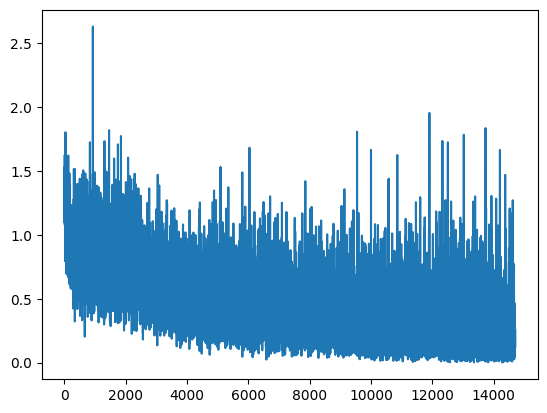

In [33]:
plt.plot(train_losses)

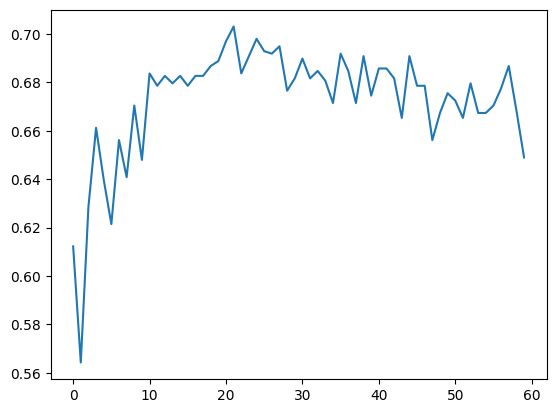

In [34]:
plt.plot(test_accuracy)

In [36]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=40, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m18mfcc40_best_22epoch.pt
Correct: 689/976 (0.7059)
{'acc_detail': tensor([0.7668, 0.6544, 0.7402, 0.6548], device='cuda:0'),
 'acc_unweighted': tensor(0.7040, device='cuda:0'),
 'acc_weighted': tensor(0.7059, device='cuda:0'),
 'f1s_detail': tensor([0.7729, 0.6499, 0.7520, 0.6433], device='cuda:0'),
 'f1s_unweighted': tensor(0.7045, device='cuda:0'),
 'f1s_weighted': tensor(0.7066, device='cuda:0'),
 'precision_detail': tensor([0.7791, 0.6455, 0.7642, 0.6322], device='cuda:0'),
 'recall_detail': tensor([0.7668, 0.6544, 0.7402, 0.6548], device='cuda:0'),
 'rocauc': tensor(0.8969, device='cuda:0'),
 'rocauc_detail': tensor([0.9297, 0.8878, 0.9305, 0.8397], device='cuda:0'),
 'uar': tensor(0.7040, device='cuda:0'),
 'wap': tensor(0.7076, device='cuda:0')}


tensor([[194,   9,   2,  48],
        [  6, 142,  45,  24],
        [  2,  40, 188,  24],
        [ 47,  29,  11, 165]], device='cuda:0')

In [37]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
# train_losses = []
# test_accuracy = []

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                  | 0.006535947712418301/40 [00:00<38:12, 57.32s/it]

Train Epoch: 61 [0/3920 (0%)]	Loss: 0.083011
Mem before-during-after: 26249728 29225984 32274944


  0%|                                   | 0.13725490196078433/40 [00:08<38:30, 57.97s/it]

Train Epoch: 61 [640/3920 (16%)]	Loss: 0.260361
Mem before-during-after: 32274944 35155456 32274944


  1%|▏                                   | 0.2679738562091499/40 [00:15<39:06, 59.05s/it]

Train Epoch: 61 [1280/3920 (33%)]	Loss: 0.179420
Mem before-during-after: 32274944 34284544 32274944


  1%|▎                                   | 0.3986928104575154/40 [00:23<38:20, 58.09s/it]

Train Epoch: 61 [1920/3920 (49%)]	Loss: 0.200256
Mem before-during-after: 32274944 35119104 32274944


  1%|▍                                    | 0.529411764705881/40 [00:31<38:34, 58.65s/it]

Train Epoch: 61 [2560/3920 (65%)]	Loss: 0.357457
Mem before-during-after: 32274944 34669056 32274944


  2%|▌                                   | 0.6601307189542466/40 [00:38<37:24, 57.05s/it]

Train Epoch: 61 [3200/3920 (82%)]	Loss: 0.041729
Mem before-during-after: 32274944 34648576 32274944


  2%|▋                                   | 0.7908496732026121/40 [00:46<39:10, 59.96s/it]

Train Epoch: 61 [3840/3920 (98%)]	Loss: 0.037911
Mem before-during-after: 32274944 34181120 32274944


  3%|▉                                   | 1.0032679738562063/40 [00:58<37:24, 57.54s/it]


Test Epoch: 61	Accuracy: 655/976 (67%)

Train Epoch: 62 [0/3920 (0%)]	Loss: 0.883545
Mem before-during-after: 32273920 34048000 32274944


  3%|█                                    | 1.137254901960781/40 [01:06<37:38, 58.11s/it]

Train Epoch: 62 [640/3920 (16%)]	Loss: 0.003776
Mem before-during-after: 32274944 35082752 32274944


  3%|█▏                                  | 1.2679738562091465/40 [01:14<37:56, 58.77s/it]

Train Epoch: 62 [1280/3920 (33%)]	Loss: 0.840151
Mem before-during-after: 32274944 35082752 32274944


  3%|█▎                                   | 1.398692810457512/40 [01:21<37:55, 58.95s/it]

Train Epoch: 62 [1920/3920 (49%)]	Loss: 0.182483
Mem before-during-after: 32274944 34269696 32274944


  4%|█▍                                  | 1.5294117647058776/40 [01:29<37:22, 58.30s/it]

Train Epoch: 62 [2560/3920 (65%)]	Loss: 0.117965
Mem before-during-after: 32274944 34269696 32274944


  4%|█▍                                  | 1.6601307189542431/40 [01:37<38:16, 59.91s/it]

Train Epoch: 62 [3200/3920 (82%)]	Loss: 0.130106
Mem before-during-after: 32274944 35119104 32274944


  4%|█▌                                  | 1.7908496732026087/40 [01:44<38:06, 59.84s/it]

Train Epoch: 62 [3840/3920 (98%)]	Loss: 0.443885
Mem before-during-after: 32274944 34742784 32274944


  5%|█▊                                   | 2.003267973856203/40 [01:57<37:23, 59.05s/it]


Test Epoch: 62	Accuracy: 645/976 (66%)

Train Epoch: 63 [0/3920 (0%)]	Loss: 0.090262
Mem before-during-after: 32273920 35010048 32274944


  5%|█▉                                  | 2.1372549019607776/40 [02:05<38:03, 60.30s/it]

Train Epoch: 63 [640/3920 (16%)]	Loss: 0.129714
Mem before-during-after: 32274944 34842624 32274944


  6%|██                                   | 2.267973856209143/40 [02:13<36:58, 58.80s/it]

Train Epoch: 63 [1280/3920 (33%)]	Loss: 0.464401
Mem before-during-after: 32274944 34269696 32274944


  6%|██▏                                 | 2.3986928104575087/40 [02:20<36:28, 58.21s/it]

Train Epoch: 63 [1920/3920 (49%)]	Loss: 0.330167
Mem before-during-after: 32274944 35119104 32274944


  6%|██▎                                  | 2.526143790849665/40 [02:28<36:37, 58.63s/it]

Train Epoch: 63 [2560/3920 (65%)]	Loss: 0.351635
Mem before-during-after: 32274944 34018304 32274944


  7%|██▍                                 | 2.6568627450980307/40 [02:35<36:03, 57.92s/it]

Train Epoch: 63 [3200/3920 (82%)]	Loss: 0.088043
Mem before-during-after: 32274944 35119104 32274944


  7%|██▌                                 | 2.7908496732026054/40 [02:43<35:47, 57.71s/it]

Train Epoch: 63 [3840/3920 (98%)]	Loss: 0.014903
Mem before-during-after: 32274944 34299392 32274944


  8%|██▋                                 | 3.0032679738561994/40 [02:56<35:50, 58.13s/it]


Test Epoch: 63	Accuracy: 664/976 (68%)

Train Epoch: 64 [0/3920 (0%)]	Loss: 0.370992
Mem before-during-after: 32273920 34210816 32274944


  8%|██▉                                  | 3.137254901960774/40 [03:04<36:19, 59.13s/it]

Train Epoch: 64 [640/3920 (16%)]	Loss: 0.454598
Mem before-during-after: 32274944 34166272 32274944


  8%|██▉                                 | 3.2679738562091396/40 [03:11<35:44, 58.39s/it]

Train Epoch: 64 [1280/3920 (33%)]	Loss: 0.031620
Mem before-during-after: 32274944 34299392 32274944


  8%|███▏                                 | 3.398692810457505/40 [03:19<35:21, 57.97s/it]

Train Epoch: 64 [1920/3920 (49%)]	Loss: 0.176174
Mem before-during-after: 32274944 34181120 32274944


  9%|███▏                                | 3.5294117647058707/40 [03:27<34:59, 57.57s/it]

Train Epoch: 64 [2560/3920 (65%)]	Loss: 0.215625
Mem before-during-after: 32274944 34772480 32274944


  9%|███▎                                | 3.6601307189542363/40 [03:34<35:37, 58.82s/it]

Train Epoch: 64 [3200/3920 (82%)]	Loss: 0.032004
Mem before-during-after: 32274944 34299392 32274944


  9%|███▌                                 | 3.790849673202602/40 [03:42<34:51, 57.76s/it]

Train Epoch: 64 [3840/3920 (98%)]	Loss: 0.310576
Mem before-during-after: 32274944 34915328 32274944


 10%|███▋                                 | 4.003267973856196/40 [03:54<35:11, 58.66s/it]


Test Epoch: 64	Accuracy: 664/976 (68%)

Train Epoch: 65 [0/3920 (0%)]	Loss: 0.164611
Mem before-during-after: 32273920 34254848 32274944


 10%|███▋                                | 4.1372549019607705/40 [04:02<34:36, 57.89s/it]

Train Epoch: 65 [640/3920 (16%)]	Loss: 0.157980
Mem before-during-after: 32274944 34269696 32274944


 11%|███▉                                 | 4.267973856209136/40 [04:09<35:10, 59.06s/it]

Train Epoch: 65 [1280/3920 (33%)]	Loss: 0.220903
Mem before-during-after: 32274944 35119104 32274944


 11%|████                                 | 4.398692810457502/40 [04:17<34:36, 58.32s/it]

Train Epoch: 65 [1920/3920 (49%)]	Loss: 0.074775
Mem before-during-after: 32274944 35082752 32274944


 11%|████▏                                | 4.529411764705867/40 [04:25<33:57, 57.45s/it]

Train Epoch: 65 [2560/3920 (65%)]	Loss: 0.157635
Mem before-during-after: 32274944 34136576 32274944


 12%|████▎                                | 4.660130718954233/40 [04:32<34:27, 58.50s/it]

Train Epoch: 65 [3200/3920 (82%)]	Loss: 0.611942
Mem before-during-after: 32274944 33974272 32274944


 12%|████▍                                | 4.790849673202598/40 [04:40<33:40, 57.39s/it]

Train Epoch: 65 [3840/3920 (98%)]	Loss: 0.510415
Mem before-during-after: 32274944 34842624 32274944


 13%|████▋                                | 5.003267973856192/40 [04:52<33:02, 56.66s/it]


Test Epoch: 65	Accuracy: 654/976 (67%)

Train Epoch: 66 [0/3920 (0%)]	Loss: 0.056670
Mem before-during-after: 32273920 34299392 32274944


 13%|████▊                                | 5.137254901960767/40 [05:00<33:41, 57.98s/it]

Train Epoch: 66 [640/3920 (16%)]	Loss: 0.191393
Mem before-during-after: 32274944 35286528 32274944


 13%|████▋                               | 5.2679738562091325/40 [05:07<33:28, 57.83s/it]

Train Epoch: 66 [1280/3920 (33%)]	Loss: 0.414036
Mem before-during-after: 32274944 34166272 32274944


 13%|████▉                                | 5.398692810457498/40 [05:15<33:51, 58.70s/it]

Train Epoch: 66 [1920/3920 (49%)]	Loss: 0.061340
Mem before-during-after: 32274944 34284544 32274944


 14%|█████                                | 5.529411764705864/40 [05:23<33:05, 57.60s/it]

Train Epoch: 66 [2560/3920 (65%)]	Loss: 0.027802
Mem before-during-after: 32274944 33921024 32274944


 14%|█████▏                               | 5.660130718954229/40 [05:30<32:29, 56.76s/it]

Train Epoch: 66 [3200/3920 (82%)]	Loss: 0.259664
Mem before-during-after: 32274944 35119104 32274944


 14%|█████▎                               | 5.790849673202595/40 [05:38<33:00, 57.89s/it]

Train Epoch: 66 [3840/3920 (98%)]	Loss: 0.249439
Mem before-during-after: 32274944 35286528 32274944


 15%|█████▌                               | 6.003267973856189/40 [05:50<32:52, 58.02s/it]


Test Epoch: 66	Accuracy: 661/976 (67%)

Train Epoch: 67 [0/3920 (0%)]	Loss: 0.243885
Mem before-during-after: 32273920 34210816 32274944


 15%|█████▋                               | 6.137254901960763/40 [05:58<32:26, 57.47s/it]

Train Epoch: 67 [640/3920 (16%)]	Loss: 0.164720
Mem before-during-after: 32274944 35082752 32274944


 16%|█████▊                               | 6.267973856209129/40 [06:05<32:49, 58.37s/it]

Train Epoch: 67 [1280/3920 (33%)]	Loss: 0.511458
Mem before-during-after: 32274944 34648576 32274944


 16%|█████▊                              | 6.3986928104574945/40 [06:13<32:41, 58.37s/it]

Train Epoch: 67 [1920/3920 (49%)]	Loss: 0.312966
Mem before-during-after: 32274944 34890752 32274944


 16%|██████▏                               | 6.52941176470586/40 [06:20<32:48, 58.83s/it]

Train Epoch: 67 [2560/3920 (65%)]	Loss: 0.067804
Mem before-during-after: 32274944 34210816 32274944


 17%|██████▏                              | 6.660130718954226/40 [06:28<32:56, 59.29s/it]

Train Epoch: 67 [3200/3920 (82%)]	Loss: 0.625056
Mem before-during-after: 32274944 34092544 32274944


 17%|██████▎                              | 6.787581699346382/40 [06:36<33:51, 61.16s/it]

Train Epoch: 67 [3840/3920 (98%)]	Loss: 0.365648
Mem before-during-after: 32274944 34669056 32274944


 18%|██████▍                              | 7.003267973856185/40 [06:48<31:06, 56.56s/it]


Test Epoch: 67	Accuracy: 634/976 (65%)

Train Epoch: 68 [0/3920 (0%)]	Loss: 0.305880
Mem before-during-after: 32273920 34181120 32274944


 18%|██████▊                               | 7.13725490196076/40 [06:56<32:06, 58.62s/it]

Train Epoch: 68 [640/3920 (16%)]	Loss: 0.056339
Mem before-during-after: 32274944 35286528 32274944


 18%|██████▋                              | 7.267973856209125/40 [07:03<31:40, 58.06s/it]

Train Epoch: 68 [1280/3920 (33%)]	Loss: 0.874833
Mem before-during-after: 32274944 34092544 32274944


 18%|██████▊                              | 7.398692810457491/40 [07:11<31:13, 57.47s/it]

Train Epoch: 68 [1920/3920 (49%)]	Loss: 0.347945
Mem before-during-after: 32274944 34151424 32274944


 19%|██████▊                             | 7.5294117647058565/40 [07:18<31:11, 57.65s/it]

Train Epoch: 68 [2560/3920 (65%)]	Loss: 0.138125
Mem before-during-after: 32274944 34639360 32274944


 19%|███████                              | 7.660130718954222/40 [07:26<31:23, 58.23s/it]

Train Epoch: 68 [3200/3920 (82%)]	Loss: 0.000118
Mem before-during-after: 32274944 34284544 32274944


 19%|███████▏                             | 7.790849673202588/40 [07:34<30:54, 57.56s/it]

Train Epoch: 68 [3840/3920 (98%)]	Loss: 0.128323
Mem before-during-after: 32274944 34440704 32274944


 20%|███████▍                             | 8.003267973856182/40 [07:46<30:37, 57.42s/it]


Test Epoch: 68	Accuracy: 660/976 (67%)

Train Epoch: 69 [0/3920 (0%)]	Loss: 0.259962
Mem before-during-after: 32273920 34951680 32274944


 20%|███████▌                             | 8.137254901960757/40 [07:54<30:43, 57.86s/it]

Train Epoch: 69 [640/3920 (16%)]	Loss: 0.060500
Mem before-during-after: 32274944 35119104 32274944


 21%|███████▋                             | 8.267973856209123/40 [08:01<30:34, 57.80s/it]

Train Epoch: 69 [1280/3920 (33%)]	Loss: 0.201603
Mem before-during-after: 32274944 35082752 32274944


 21%|███████▊                             | 8.398692810457488/40 [08:09<30:53, 58.64s/it]

Train Epoch: 69 [1920/3920 (49%)]	Loss: 0.187674
Mem before-during-after: 32274944 34915328 32274944


 21%|███████▉                             | 8.529411764705854/40 [08:17<30:37, 58.37s/it]

Train Epoch: 69 [2560/3920 (65%)]	Loss: 1.020863
Mem before-during-after: 32274944 34440704 32274944


 22%|████████▏                             | 8.66013071895422/40 [08:24<30:05, 57.62s/it]

Train Epoch: 69 [3200/3920 (82%)]	Loss: 0.222271
Mem before-during-after: 32274944 34136576 32274944


 22%|████████▏                            | 8.790849673202585/40 [08:32<29:49, 57.33s/it]

Train Epoch: 69 [3840/3920 (98%)]	Loss: 0.242317
Mem before-during-after: 32274944 34806272 32274944


 23%|████████▎                            | 9.003267973856179/40 [08:44<30:06, 58.29s/it]


Test Epoch: 69	Accuracy: 653/976 (67%)

Train Epoch: 70 [0/3920 (0%)]	Loss: 0.187047
Mem before-during-after: 32273920 34639360 32274944


 23%|████████▍                            | 9.137254901960754/40 [08:52<29:42, 57.74s/it]

Train Epoch: 70 [640/3920 (16%)]	Loss: 0.255261
Mem before-during-after: 32274944 34284544 32274944


 23%|████████▊                             | 9.26797385620912/40 [08:59<29:04, 56.76s/it]

Train Epoch: 70 [1280/3920 (33%)]	Loss: 0.230995
Mem before-during-after: 32274944 35119104 32274944


 23%|████████▋                            | 9.395424836601276/40 [09:07<29:44, 58.30s/it]

Train Epoch: 70 [1920/3920 (49%)]	Loss: 0.301421
Mem before-during-after: 32274944 34181120 32274944


 24%|█████████                             | 9.52941176470585/40 [09:14<29:49, 58.71s/it]

Train Epoch: 70 [2560/3920 (65%)]	Loss: 0.773104
Mem before-during-after: 32274944 35119104 32274944


 24%|████████▉                            | 9.660130718954216/40 [09:22<29:21, 58.05s/it]

Train Epoch: 70 [3200/3920 (82%)]	Loss: 0.591604
Mem before-during-after: 32274944 34669056 32274944


 24%|█████████                            | 9.790849673202581/40 [09:30<29:04, 57.76s/it]

Train Epoch: 70 [3840/3920 (98%)]	Loss: 0.300528
Mem before-during-after: 32274944 35286528 32274944


 25%|█████████                           | 10.003267973856175/40 [09:42<28:28, 56.96s/it]


Test Epoch: 70	Accuracy: 655/976 (67%)

Train Epoch: 71 [0/3920 (0%)]	Loss: 0.679941
Mem before-during-after: 32273920 34077696 32274944


 25%|█████████▍                           | 10.13725490196075/40 [09:49<29:03, 58.37s/it]

Train Epoch: 71 [640/3920 (16%)]	Loss: 0.070991
Mem before-during-after: 32274944 34195968 32274944


 26%|█████████▏                          | 10.267973856209116/40 [09:57<29:15, 59.04s/it]

Train Epoch: 71 [1280/3920 (33%)]	Loss: 0.565483
Mem before-during-after: 32274944 35191808 32274944


 26%|█████████▎                          | 10.398692810457481/40 [10:05<28:50, 58.45s/it]

Train Epoch: 71 [1920/3920 (49%)]	Loss: 0.195638
Mem before-during-after: 32274944 34683904 32274944


 26%|█████████▍                          | 10.529411764705847/40 [10:12<28:15, 57.52s/it]

Train Epoch: 71 [2560/3920 (65%)]	Loss: 0.126613
Mem before-during-after: 32274944 35191808 32274944


 27%|█████████▌                          | 10.660130718954212/40 [10:20<28:45, 58.81s/it]

Train Epoch: 71 [3200/3920 (82%)]	Loss: 0.412069
Mem before-during-after: 32274944 34769920 32274944


 27%|█████████▋                          | 10.790849673202578/40 [10:28<28:56, 59.46s/it]

Train Epoch: 71 [3840/3920 (98%)]	Loss: 0.730369
Mem before-during-after: 32274944 35112448 32274944


 28%|█████████▉                          | 11.003267973856172/40 [10:40<28:42, 59.39s/it]


Test Epoch: 71	Accuracy: 654/976 (67%)

Train Epoch: 72 [0/3920 (0%)]	Loss: 0.281158
Mem before-during-after: 32273920 34842624 32274944


 28%|██████████                          | 11.137254901960747/40 [10:48<27:46, 57.75s/it]

Train Epoch: 72 [640/3920 (16%)]	Loss: 0.337087
Mem before-during-after: 32274944 35010048 32274944


 28%|██████████▏                         | 11.267973856209112/40 [10:56<27:46, 58.02s/it]

Train Epoch: 72 [1280/3920 (33%)]	Loss: 0.408698
Mem before-during-after: 32274944 34210816 32274944


 28%|██████████▎                         | 11.398692810457478/40 [11:03<27:38, 58.00s/it]

Train Epoch: 72 [1920/3920 (49%)]	Loss: 0.614786
Mem before-during-after: 32274944 34210816 32274944


 29%|██████████▍                         | 11.529411764705843/40 [11:11<28:00, 59.02s/it]

Train Epoch: 72 [2560/3920 (65%)]	Loss: 0.068720
Mem before-during-after: 32274944 35119104 32274944


 29%|██████████▍                         | 11.660130718954209/40 [11:18<26:53, 56.92s/it]

Train Epoch: 72 [3200/3920 (82%)]	Loss: 0.680175
Mem before-during-after: 32274944 34806272 32274944


 29%|██████████▌                         | 11.790849673202574/40 [11:26<27:47, 59.12s/it]

Train Epoch: 72 [3840/3920 (98%)]	Loss: 0.036111
Mem before-during-after: 32274944 34489856 32274944


 30%|██████████▊                         | 12.003267973856168/40 [11:38<26:55, 57.72s/it]


Test Epoch: 72	Accuracy: 655/976 (67%)

Train Epoch: 73 [0/3920 (0%)]	Loss: 0.707391
Mem before-during-after: 32273920 34951680 32274944


 30%|██████████▉                         | 12.137254901960743/40 [11:46<27:23, 58.98s/it]

Train Epoch: 73 [640/3920 (16%)]	Loss: 0.028527
Mem before-during-after: 32274944 35286528 32274944


 31%|███████████                         | 12.267973856209109/40 [11:54<26:27, 57.24s/it]

Train Epoch: 73 [1280/3920 (33%)]	Loss: 0.150128
Mem before-during-after: 32274944 35119104 32274944


 31%|███████████▏                        | 12.398692810457474/40 [12:01<26:46, 58.20s/it]

Train Epoch: 73 [1920/3920 (49%)]	Loss: 0.197938
Mem before-during-after: 32274944 35082752 32274944


 31%|███████████▌                         | 12.52941176470584/40 [12:09<26:40, 58.25s/it]

Train Epoch: 73 [2560/3920 (65%)]	Loss: 0.260194
Mem before-during-after: 32274944 35009024 32274944


 32%|███████████▍                        | 12.660130718954205/40 [12:17<27:16, 59.85s/it]

Train Epoch: 73 [3200/3920 (82%)]	Loss: 0.445409
Mem before-during-after: 32274944 34210816 32274944


 32%|███████████▊                         | 12.79084967320257/40 [12:24<27:08, 59.87s/it]

Train Epoch: 73 [3840/3920 (98%)]	Loss: 0.017277
Mem before-during-after: 32274944 34842624 32274944


 33%|███████████▋                        | 13.003267973856165/40 [12:37<26:32, 58.99s/it]


Test Epoch: 73	Accuracy: 646/976 (66%)

Train Epoch: 74 [0/3920 (0%)]	Loss: 0.194700
Mem before-during-after: 32273920 34254848 32274944


 33%|████████████▏                        | 13.13725490196074/40 [12:45<26:13, 58.59s/it]

Train Epoch: 74 [640/3920 (16%)]	Loss: 0.189017
Mem before-during-after: 32274944 35009024 32274944


 33%|███████████▉                        | 13.267973856209105/40 [12:52<26:03, 58.49s/it]

Train Epoch: 74 [1280/3920 (33%)]	Loss: 0.094382
Mem before-during-after: 32274944 34806272 32274944


 33%|████████████▍                        | 13.39869281045747/40 [13:00<25:51, 58.31s/it]

Train Epoch: 74 [1920/3920 (49%)]	Loss: 0.289906
Mem before-during-after: 32274944 34878976 32274944


 34%|████████████▏                       | 13.529411764705836/40 [13:08<25:37, 58.09s/it]

Train Epoch: 74 [2560/3920 (65%)]	Loss: 0.168771
Mem before-during-after: 32274944 35155456 32274944


 34%|████████████▎                       | 13.660130718954202/40 [13:16<25:42, 58.58s/it]

Train Epoch: 74 [3200/3920 (82%)]	Loss: 0.304160
Mem before-during-after: 32274944 34842624 32274944


 34%|████████████▍                       | 13.787581699346358/40 [13:23<25:58, 59.46s/it]

Train Epoch: 74 [3840/3920 (98%)]	Loss: 0.039605
Mem before-during-after: 32274944 34675200 32274944


 35%|████████████▌                       | 14.003267973856161/40 [13:36<24:46, 57.18s/it]


Test Epoch: 74	Accuracy: 656/976 (67%)

Train Epoch: 75 [0/3920 (0%)]	Loss: 0.444110
Mem before-during-after: 32273920 35082752 32274944


 35%|████████████▋                       | 14.137254901960736/40 [13:44<25:18, 58.73s/it]

Train Epoch: 75 [640/3920 (16%)]	Loss: 0.052311
Mem before-during-after: 32274944 35250176 32274944


 36%|████████████▊                       | 14.267973856209101/40 [13:51<25:02, 58.37s/it]

Train Epoch: 75 [1280/3920 (33%)]	Loss: 1.171655
Mem before-during-after: 32274944 34648576 32274944


 36%|████████████▉                       | 14.395424836601258/40 [13:59<24:56, 58.44s/it]

Train Epoch: 75 [1920/3920 (49%)]	Loss: 0.249025
Mem before-during-after: 32274944 34951680 32274944


 36%|█████████████                       | 14.529411764705833/40 [14:07<24:36, 57.97s/it]

Train Epoch: 75 [2560/3920 (65%)]	Loss: 0.366488
Mem before-during-after: 32274944 35286528 32274944


 37%|█████████████▏                      | 14.660130718954198/40 [14:14<24:28, 57.94s/it]

Train Epoch: 75 [3200/3920 (82%)]	Loss: 0.037693
Mem before-during-after: 32274944 34744320 32274944


 37%|█████████████▎                      | 14.790849673202564/40 [14:22<24:28, 58.27s/it]

Train Epoch: 75 [3840/3920 (98%)]	Loss: 0.068325
Mem before-during-after: 32274944 34181120 32274944


 38%|█████████████▌                      | 15.003267973856158/40 [14:34<23:47, 57.13s/it]


Test Epoch: 75	Accuracy: 665/976 (68%)

Train Epoch: 76 [0/3920 (0%)]	Loss: 0.323388
Mem before-during-after: 32273920 34062848 32274944


 38%|█████████████▌                      | 15.137254901960732/40 [14:42<24:03, 58.07s/it]

Train Epoch: 76 [640/3920 (16%)]	Loss: 0.198239
Mem before-during-after: 32274944 35155456 32274944


 38%|█████████████▋                      | 15.267973856209098/40 [14:50<23:57, 58.10s/it]

Train Epoch: 76 [1280/3920 (33%)]	Loss: 0.584445
Mem before-during-after: 32274944 34048000 32274944


 38%|█████████████▊                      | 15.398692810457463/40 [14:57<23:31, 57.39s/it]

Train Epoch: 76 [1920/3920 (49%)]	Loss: 0.504413
Mem before-during-after: 32274944 34151424 32274944


 39%|█████████████▉                      | 15.529411764705829/40 [15:05<23:42, 58.11s/it]

Train Epoch: 76 [2560/3920 (65%)]	Loss: 0.160982
Mem before-during-after: 32274944 34842624 32274944


 39%|██████████████                      | 15.660130718954195/40 [15:12<23:45, 58.58s/it]

Train Epoch: 76 [3200/3920 (82%)]	Loss: 0.178116
Mem before-during-after: 32274944 34195968 32274944


 39%|██████████████▌                      | 15.79084967320256/40 [15:20<23:24, 58.03s/it]

Train Epoch: 76 [3840/3920 (98%)]	Loss: 0.532650
Mem before-during-after: 32274944 34269696 32274944


 40%|██████████████▍                     | 16.003267973856154/40 [15:32<22:50, 57.09s/it]


Test Epoch: 76	Accuracy: 656/976 (67%)

Train Epoch: 77 [0/3920 (0%)]	Loss: 0.004555
Mem before-during-after: 32273920 34299392 32274944


 40%|███████████████▎                      | 16.1372549019608/40 [15:40<23:11, 58.31s/it]

Train Epoch: 77 [640/3920 (16%)]	Loss: 0.668919
Mem before-during-after: 32274944 34639360 32274944


 41%|██████████████▋                     | 16.267973856209238/40 [15:48<23:01, 58.21s/it]

Train Epoch: 77 [1280/3920 (33%)]	Loss: 0.462860
Mem before-during-after: 32274944 35286528 32274944


 41%|██████████████▊                     | 16.398692810457675/40 [15:55<23:13, 59.06s/it]

Train Epoch: 77 [1920/3920 (49%)]	Loss: 0.419463
Mem before-during-after: 32274944 35112448 32274944


 41%|███████████████▎                     | 16.52941176470611/40 [16:03<22:17, 56.99s/it]

Train Epoch: 77 [2560/3920 (65%)]	Loss: 0.649564
Mem before-during-after: 32274944 35119104 32274944


 42%|██████████████▉                     | 16.660130718954548/40 [16:11<23:15, 59.79s/it]

Train Epoch: 77 [3200/3920 (82%)]	Loss: 0.101988
Mem before-during-after: 32274944 34299392 32274944


 42%|███████████████                     | 16.790849673202985/40 [16:18<22:34, 58.35s/it]

Train Epoch: 77 [3840/3920 (98%)]	Loss: 0.431958
Mem before-during-after: 32274944 34254848 32274944


 43%|███████████████▎                    | 17.003267973856694/40 [16:30<21:48, 56.92s/it]


Test Epoch: 77	Accuracy: 651/976 (66%)

Train Epoch: 78 [0/3920 (0%)]	Loss: 0.123156
Mem before-during-after: 32273920 35250176 32274944


 43%|███████████████▊                     | 17.13725490196134/40 [16:38<21:58, 57.68s/it]

Train Epoch: 78 [640/3920 (16%)]	Loss: 0.398950
Mem before-during-after: 32274944 33921024 32274944


 43%|███████████████▌                    | 17.267973856209778/40 [16:46<21:59, 58.03s/it]

Train Epoch: 78 [1280/3920 (33%)]	Loss: 0.110713
Mem before-during-after: 32274944 35119104 32274944


 43%|███████████████▋                    | 17.398692810458215/40 [16:53<21:59, 58.40s/it]

Train Epoch: 78 [1920/3920 (49%)]	Loss: 0.095641
Mem before-during-after: 32274944 35119104 32274944


 44%|████████████████▏                    | 17.52941176470665/40 [17:01<21:31, 57.49s/it]

Train Epoch: 78 [2560/3920 (65%)]	Loss: 0.239047
Mem before-during-after: 32274944 35127296 32274944


 44%|███████████████▉                    | 17.660130718955088/40 [17:09<21:49, 58.61s/it]

Train Epoch: 78 [3200/3920 (82%)]	Loss: 0.540413
Mem before-during-after: 32274944 34299392 32274944


 44%|████████████████                    | 17.790849673203525/40 [17:16<21:21, 57.72s/it]

Train Epoch: 78 [3840/3920 (98%)]	Loss: 0.223131
Mem before-during-after: 32274944 35191808 32274944


 45%|████████████████▏                   | 18.003267973857234/40 [17:28<21:05, 57.53s/it]


Test Epoch: 78	Accuracy: 634/976 (65%)

Train Epoch: 79 [0/3920 (0%)]	Loss: 0.081812
Mem before-during-after: 32273920 34254848 32274944


 45%|████████████████▊                    | 18.13725490196188/40 [17:36<21:19, 58.52s/it]

Train Epoch: 79 [640/3920 (16%)]	Loss: 0.026813
Mem before-during-after: 32274944 35250176 32274944


 46%|████████████████▍                   | 18.267973856210318/40 [17:44<20:24, 56.34s/it]

Train Epoch: 79 [1280/3920 (33%)]	Loss: 0.358786
Mem before-during-after: 32274944 34269696 32274944


 46%|████████████████▌                   | 18.398692810458755/40 [17:51<21:05, 58.59s/it]

Train Epoch: 79 [1920/3920 (49%)]	Loss: 0.259493
Mem before-during-after: 32274944 34033152 32274944


 46%|█████████████████▏                   | 18.52941176470719/40 [17:59<20:54, 58.43s/it]

Train Epoch: 79 [2560/3920 (65%)]	Loss: 0.071531
Mem before-during-after: 32274944 34744320 32274944


 47%|████████████████▊                   | 18.660130718955628/40 [18:07<21:07, 59.38s/it]

Train Epoch: 79 [3200/3920 (82%)]	Loss: 0.270759
Mem before-during-after: 32274944 35250176 32274944


 47%|████████████████▉                   | 18.790849673204065/40 [18:14<20:56, 59.26s/it]

Train Epoch: 79 [3840/3920 (98%)]	Loss: 0.156322
Mem before-during-after: 32274944 35082752 32274944


 48%|█████████████████                   | 19.003267973857774/40 [18:27<20:02, 57.25s/it]


Test Epoch: 79	Accuracy: 661/976 (67%)

Train Epoch: 80 [0/3920 (0%)]	Loss: 0.267301
Mem before-during-after: 32273920 34769920 32274944


 48%|█████████████████▋                   | 19.13725490196242/40 [18:34<20:35, 59.22s/it]

Train Epoch: 80 [640/3920 (16%)]	Loss: 0.194145
Mem before-during-after: 32274944 34683904 32274944


 48%|█████████████████▊                   | 19.26797385621086/40 [18:42<19:53, 57.59s/it]

Train Epoch: 80 [1280/3920 (33%)]	Loss: 0.022730
Mem before-during-after: 32274944 35191808 32274944


 48%|█████████████████▍                  | 19.398692810459295/40 [18:50<19:53, 57.94s/it]

Train Epoch: 80 [1920/3920 (49%)]	Loss: 0.525655
Mem before-during-after: 32274944 34299392 32274944


 49%|██████████████████                   | 19.52941176470773/40 [18:57<19:43, 57.81s/it]

Train Epoch: 80 [2560/3920 (65%)]	Loss: 0.270447
Mem before-during-after: 32274944 34842624 32274944


 49%|█████████████████▋                  | 19.660130718956168/40 [19:05<19:47, 58.36s/it]

Train Epoch: 80 [3200/3920 (82%)]	Loss: 0.114819
Mem before-during-after: 32274944 34669056 32274944


 49%|█████████████████▊                  | 19.790849673204605/40 [19:13<19:57, 59.27s/it]

Train Epoch: 80 [3840/3920 (98%)]	Loss: 0.202383
Mem before-during-after: 32274944 34166272 32274944


 50%|██████████████████                  | 20.003267973858314/40 [19:25<18:58, 56.91s/it]


Test Epoch: 80	Accuracy: 662/976 (68%)

Train Epoch: 81 [0/3920 (0%)]	Loss: 0.089819
Mem before-during-after: 32273920 33921024 32274944


 50%|██████████████████▋                  | 20.13725490196296/40 [19:32<18:54, 57.13s/it]

Train Epoch: 81 [640/3920 (16%)]	Loss: 0.522110
Mem before-during-after: 32274944 34744320 32274944


 51%|███████████████████▎                  | 20.2679738562114/40 [19:40<19:04, 58.00s/it]

Train Epoch: 81 [1280/3920 (33%)]	Loss: 0.099552
Mem before-during-after: 32274944 34048000 32274944


 51%|██████████████████▎                 | 20.398692810459835/40 [19:48<18:56, 58.00s/it]

Train Epoch: 81 [1920/3920 (49%)]	Loss: 0.331539
Mem before-during-after: 32274944 34166272 32274944


 51%|██████████████████▉                  | 20.52941176470827/40 [19:55<18:26, 56.85s/it]

Train Epoch: 81 [2560/3920 (65%)]	Loss: 0.052652
Mem before-during-after: 32274944 34210816 32274944


 52%|██████████████████▌                 | 20.660130718956708/40 [20:03<20:05, 62.35s/it]

Train Epoch: 81 [3200/3920 (82%)]	Loss: 0.343775
Mem before-during-after: 32274944 35046400 32274944


 52%|██████████████████▋                 | 20.790849673205145/40 [20:11<18:57, 59.21s/it]

Train Epoch: 81 [3840/3920 (98%)]	Loss: 0.308742
Mem before-during-after: 32274944 34151424 32274944


 53%|██████████████████▉                 | 21.003267973858854/40 [20:23<18:03, 57.02s/it]


Test Epoch: 81	Accuracy: 657/976 (67%)

Train Epoch: 82 [0/3920 (0%)]	Loss: 0.115573
Mem before-during-after: 32273920 34284544 32274944


 53%|████████████████████                  | 21.1372549019635/40 [20:31<18:12, 57.91s/it]

Train Epoch: 82 [640/3920 (16%)]	Loss: 0.160708
Mem before-during-after: 32274944 34254848 32274944


 53%|███████████████████▋                 | 21.26797385621194/40 [20:38<18:09, 58.16s/it]

Train Epoch: 82 [1280/3920 (33%)]	Loss: 0.517558
Mem before-during-after: 32274944 35082752 32274944


 53%|███████████████████▎                | 21.398692810460375/40 [20:46<18:05, 58.38s/it]

Train Epoch: 82 [1920/3920 (49%)]	Loss: 0.288352
Mem before-during-after: 32274944 34769920 32274944


 54%|███████████████████▉                 | 21.52941176470881/40 [20:53<17:47, 57.82s/it]

Train Epoch: 82 [2560/3920 (65%)]	Loss: 0.168740
Mem before-during-after: 32274944 34806272 32274944


 54%|███████████████████▍                | 21.660130718957248/40 [21:01<17:45, 58.07s/it]

Train Epoch: 82 [3200/3920 (82%)]	Loss: 0.042078
Mem before-during-after: 32274944 34269696 32274944


 54%|███████████████████▌                | 21.790849673205685/40 [21:09<17:40, 58.23s/it]

Train Epoch: 82 [3840/3920 (98%)]	Loss: 0.233734
Mem before-during-after: 32274944 34432512 32274944


 55%|███████████████████▊                | 22.003267973859394/40 [21:21<17:56, 59.79s/it]


Test Epoch: 82	Accuracy: 622/976 (63%)

Train Epoch: 83 [0/3920 (0%)]	Loss: 0.258284
Mem before-during-after: 32273920 34890752 32274944


 55%|████████████████████▍                | 22.13725490196404/40 [21:29<17:05, 57.42s/it]

Train Epoch: 83 [640/3920 (16%)]	Loss: 0.020862
Mem before-during-after: 32274944 34136576 32274944


 56%|████████████████████▌                | 22.26797385621248/40 [21:36<17:09, 58.04s/it]

Train Epoch: 83 [1280/3920 (33%)]	Loss: 0.192589
Mem before-during-after: 32274944 34878976 32274944


 56%|████████████████████▏               | 22.398692810460915/40 [21:44<17:11, 58.61s/it]

Train Epoch: 83 [1920/3920 (49%)]	Loss: 0.257076
Mem before-during-after: 32274944 34254848 32274944


 56%|████████████████████▊                | 22.52941176470935/40 [21:52<16:33, 56.84s/it]

Train Epoch: 83 [2560/3920 (65%)]	Loss: 0.160110
Mem before-during-after: 32274944 34048000 32274944


 57%|████████████████████▍               | 22.660130718957788/40 [21:59<16:51, 58.35s/it]

Train Epoch: 83 [3200/3920 (82%)]	Loss: 0.279454
Mem before-during-after: 32274944 34210816 32274944


 57%|████████████████████▌               | 22.790849673206225/40 [22:07<16:43, 58.34s/it]

Train Epoch: 83 [3840/3920 (98%)]	Loss: 0.021340
Mem before-during-after: 32274944 33921024 32274944


 58%|████████████████████▋               | 23.000000000003723/40 [22:19<16:18, 57.55s/it]


Test Epoch: 83	Accuracy: 652/976 (67%)



 58%|████████████████████▋               | 23.006535947716145/40 [22:19<16:45, 59.16s/it]

Train Epoch: 84 [0/3920 (0%)]	Loss: 0.132711
Mem before-during-after: 32273920 34136576 32274944


 58%|█████████████████████▍               | 23.13725490196458/40 [22:27<16:31, 58.80s/it]

Train Epoch: 84 [640/3920 (16%)]	Loss: 0.248370
Mem before-during-after: 32274944 34769920 32274944


 58%|█████████████████████▌               | 23.26797385621302/40 [22:35<16:27, 59.00s/it]

Train Epoch: 84 [1280/3920 (33%)]	Loss: 0.127118
Mem before-during-after: 32274944 34951680 32274944


 58%|█████████████████████               | 23.398692810461455/40 [22:42<16:12, 58.55s/it]

Train Epoch: 84 [1920/3920 (49%)]	Loss: 0.066230
Mem before-during-after: 32274944 35119104 32274944


 59%|█████████████████████▊               | 23.52941176470989/40 [22:50<16:16, 59.26s/it]

Train Epoch: 84 [2560/3920 (65%)]	Loss: 0.309550
Mem before-during-after: 32274944 34878976 32274944


 59%|█████████████████████▎              | 23.660130718958328/40 [22:58<15:39, 57.53s/it]

Train Epoch: 84 [3200/3920 (82%)]	Loss: 0.274743
Mem before-during-after: 32274944 34806272 32274944


 59%|█████████████████████▍              | 23.790849673206765/40 [23:05<15:36, 57.79s/it]

Train Epoch: 84 [3840/3920 (98%)]	Loss: 0.206099
Mem before-during-after: 32274944 35119104 32274944


 60%|█████████████████████▌              | 24.003267973860474/40 [23:17<15:05, 56.58s/it]


Test Epoch: 84	Accuracy: 650/976 (66%)

Train Epoch: 85 [0/3920 (0%)]	Loss: 0.045474
Mem before-during-after: 32273920 34951680 32274944


 60%|██████████████████████▎              | 24.13725490196512/40 [23:25<15:34, 58.91s/it]

Train Epoch: 85 [640/3920 (16%)]	Loss: 0.228223
Mem before-during-after: 32274944 34166272 32274944


 61%|██████████████████████▍              | 24.26797385621356/40 [23:33<15:16, 58.23s/it]

Train Epoch: 85 [1280/3920 (33%)]	Loss: 0.081451
Mem before-during-after: 32274944 35191808 32274944


 61%|█████████████████████▉              | 24.398692810461995/40 [23:40<15:17, 58.82s/it]

Train Epoch: 85 [1920/3920 (49%)]	Loss: 0.058766
Mem before-during-after: 32274944 35286528 32274944


 61%|██████████████████████▋              | 24.52941176471043/40 [23:48<14:45, 57.22s/it]

Train Epoch: 85 [2560/3920 (65%)]	Loss: 0.320446
Mem before-during-after: 32274944 34254848 32274944


 62%|██████████████████████▏             | 24.660130718958868/40 [23:56<15:11, 59.41s/it]

Train Epoch: 85 [3200/3920 (82%)]	Loss: 0.018126
Mem before-during-after: 32274944 35250176 32274944


 62%|██████████████████████▎             | 24.790849673207305/40 [24:03<14:56, 58.97s/it]

Train Epoch: 85 [3840/3920 (98%)]	Loss: 0.040792
Mem before-during-after: 32274944 35250176 32274944


 63%|██████████████████████▌             | 25.003267973861014/40 [24:16<14:41, 58.75s/it]


Test Epoch: 85	Accuracy: 639/976 (65%)

Train Epoch: 86 [0/3920 (0%)]	Loss: 0.225032
Mem before-during-after: 32273920 35250176 32274944


 63%|███████████████████████▎             | 25.13725490196566/40 [24:24<14:39, 59.18s/it]

Train Epoch: 86 [640/3920 (16%)]	Loss: 0.209108
Mem before-during-after: 32274944 35286528 32274944


 63%|████████████████████████              | 25.2679738562141/40 [24:31<14:05, 57.41s/it]

Train Epoch: 86 [1280/3920 (33%)]	Loss: 0.045936
Mem before-during-after: 32274944 35046400 32274944


 63%|██████████████████████▊             | 25.398692810462535/40 [24:39<14:21, 59.02s/it]

Train Epoch: 86 [1920/3920 (49%)]	Loss: 0.216468
Mem before-during-after: 32274944 34166272 32274944


 64%|███████████████████████▌             | 25.52941176471097/40 [24:47<14:10, 58.75s/it]

Train Epoch: 86 [2560/3920 (65%)]	Loss: 0.438750
Mem before-during-after: 32274944 34062848 32274944


 64%|███████████████████████             | 25.660130718959408/40 [24:54<13:35, 56.86s/it]

Train Epoch: 86 [3200/3920 (82%)]	Loss: 0.365584
Mem before-during-after: 32274944 34489856 32274944


 64%|███████████████████████▏            | 25.790849673207845/40 [25:02<13:48, 58.28s/it]

Train Epoch: 86 [3840/3920 (98%)]	Loss: 0.297577
Mem before-during-after: 32274944 34062848 32274944


 65%|███████████████████████▍            | 26.003267973861554/40 [25:14<13:04, 56.05s/it]


Test Epoch: 86	Accuracy: 661/976 (67%)

Train Epoch: 87 [0/3920 (0%)]	Loss: 0.080136
Mem before-during-after: 32273920 35082752 32274944


 65%|████████████████████████▊             | 26.1372549019662/40 [25:22<13:31, 58.54s/it]

Train Epoch: 87 [640/3920 (16%)]	Loss: 0.630243
Mem before-during-after: 32274944 34092544 32274944


 66%|████████████████████████▎            | 26.26797385621464/40 [25:29<13:23, 58.51s/it]

Train Epoch: 87 [1280/3920 (33%)]	Loss: 0.299079
Mem before-during-after: 32274944 34151424 32274944


 66%|███████████████████████▊            | 26.398692810463075/40 [25:37<13:00, 57.36s/it]

Train Epoch: 87 [1920/3920 (49%)]	Loss: 0.004660
Mem before-during-after: 32274944 34269696 32274944


 66%|████████████████████████▌            | 26.52941176471151/40 [25:45<13:04, 58.23s/it]

Train Epoch: 87 [2560/3920 (65%)]	Loss: 0.385928
Mem before-during-after: 32274944 34136576 32274944


 67%|███████████████████████▉            | 26.660130718959948/40 [25:52<12:54, 58.04s/it]

Train Epoch: 87 [3200/3920 (82%)]	Loss: 0.686178
Mem before-during-after: 32274944 34890752 32274944


 67%|████████████████████████            | 26.790849673208385/40 [26:00<12:47, 58.09s/it]

Train Epoch: 87 [3840/3920 (98%)]	Loss: 0.306835
Mem before-during-after: 32274944 35250176 32274944


 68%|████████████████████████▎           | 27.003267973862094/40 [26:12<12:39, 58.41s/it]


Test Epoch: 87	Accuracy: 656/976 (67%)

Train Epoch: 88 [0/3920 (0%)]	Loss: 0.677259
Mem before-during-after: 32273920 34683904 32274944


 68%|█████████████████████████            | 27.13725490196674/40 [26:20<12:06, 56.46s/it]

Train Epoch: 88 [640/3920 (16%)]	Loss: 0.051902
Mem before-during-after: 32274944 34136576 32274944


 68%|█████████████████████████▏           | 27.26797385621518/40 [26:28<12:08, 57.18s/it]

Train Epoch: 88 [1280/3920 (33%)]	Loss: 0.085914
Mem before-during-after: 32274944 34195968 32274944


 68%|████████████████████████▋           | 27.398692810463615/40 [26:35<12:18, 58.57s/it]

Train Epoch: 88 [1920/3920 (49%)]	Loss: 0.077230
Mem before-during-after: 32274944 34769920 32274944


 69%|█████████████████████████▍           | 27.52941176471205/40 [26:43<12:16, 59.06s/it]

Train Epoch: 88 [2560/3920 (65%)]	Loss: 0.014034
Mem before-during-after: 32274944 35010048 32274944


 69%|████████████████████████▉           | 27.660130718960488/40 [26:51<11:52, 57.72s/it]

Train Epoch: 88 [3200/3920 (82%)]	Loss: 0.497299
Mem before-during-after: 32274944 34683904 32274944


 69%|█████████████████████████           | 27.790849673208925/40 [26:58<11:44, 57.68s/it]

Train Epoch: 88 [3840/3920 (98%)]	Loss: 0.083498
Mem before-during-after: 32274944 34744320 32274944


 70%|█████████████████████████▏          | 28.003267973862634/40 [27:10<11:36, 58.05s/it]


Test Epoch: 88	Accuracy: 658/976 (67%)

Train Epoch: 89 [0/3920 (0%)]	Loss: 0.046543
Mem before-during-after: 32273920 34769920 32274944


 70%|██████████████████████████           | 28.13725490196728/40 [27:18<11:35, 58.62s/it]

Train Epoch: 89 [640/3920 (16%)]	Loss: 0.433480
Mem before-during-after: 32274944 34639360 32274944


 71%|██████████████████████████▏          | 28.26797385621572/40 [27:26<11:22, 58.16s/it]

Train Epoch: 89 [1280/3920 (33%)]	Loss: 0.974550
Mem before-during-after: 32274944 34284544 32274944


 71%|█████████████████████████▌          | 28.398692810464155/40 [27:33<11:23, 58.87s/it]

Train Epoch: 89 [1920/3920 (49%)]	Loss: 0.131213
Mem before-during-after: 32274944 34489856 32274944


 71%|██████████████████████████▍          | 28.52941176471259/40 [27:41<11:09, 58.35s/it]

Train Epoch: 89 [2560/3920 (65%)]	Loss: 0.212678
Mem before-during-after: 32274944 35119104 32274944


 72%|█████████████████████████▊          | 28.660130718961028/40 [27:49<10:59, 58.19s/it]

Train Epoch: 89 [3200/3920 (82%)]	Loss: 0.025482
Mem before-during-after: 32274944 35119104 32274944


 72%|█████████████████████████▉          | 28.790849673209465/40 [27:56<11:00, 58.90s/it]

Train Epoch: 89 [3840/3920 (98%)]	Loss: 0.281229
Mem before-during-after: 32274944 35191808 32274944


 73%|██████████████████████████          | 29.003267973863174/40 [28:08<10:39, 58.13s/it]


Test Epoch: 89	Accuracy: 653/976 (67%)

Train Epoch: 90 [0/3920 (0%)]	Loss: 0.543242
Mem before-during-after: 32273920 34648576 32274944


 73%|██████████████████████████▉          | 29.13725490196782/40 [28:16<10:08, 56.03s/it]

Train Epoch: 90 [640/3920 (16%)]	Loss: 0.078609
Mem before-during-after: 32274944 35119104 32274944


 73%|███████████████████████████          | 29.26797385621626/40 [28:24<10:29, 58.62s/it]

Train Epoch: 90 [1280/3920 (33%)]	Loss: 0.175850
Mem before-during-after: 32274944 34742784 32274944


 73%|██████████████████████████▍         | 29.398692810464695/40 [28:31<10:23, 58.79s/it]

Train Epoch: 90 [1920/3920 (49%)]	Loss: 0.161245
Mem before-during-after: 32274944 35082752 32274944


 74%|███████████████████████████▎         | 29.52941176471313/40 [28:39<10:03, 57.60s/it]

Train Epoch: 90 [2560/3920 (65%)]	Loss: 0.009815
Mem before-during-after: 32274944 34915328 32274944


 74%|██████████████████████████▋         | 29.660130718961568/40 [28:47<10:03, 58.34s/it]

Train Epoch: 90 [3200/3920 (82%)]	Loss: 0.666524
Mem before-during-after: 32274944 34299392 32274944


 74%|██████████████████████████▊         | 29.790849673210005/40 [28:54<10:06, 59.38s/it]

Train Epoch: 90 [3840/3920 (98%)]	Loss: 0.530437
Mem before-during-after: 32274944 35155456 32274944


 75%|███████████████████████████         | 30.003267973863714/40 [29:07<09:44, 58.42s/it]


Test Epoch: 90	Accuracy: 647/976 (66%)

Train Epoch: 91 [0/3920 (0%)]	Loss: 0.036236
Mem before-during-after: 32273920 34254848 32274944


 75%|███████████████████████████▉         | 30.13725490196836/40 [29:15<09:29, 57.78s/it]

Train Epoch: 91 [640/3920 (16%)]	Loss: 0.233721
Mem before-during-after: 32274944 34092544 32274944


 76%|████████████████████████████▊         | 30.2679738562168/40 [29:22<09:28, 58.46s/it]

Train Epoch: 91 [1280/3920 (33%)]	Loss: 0.025369
Mem before-during-after: 32274944 34842624 32274944


 76%|███████████████████████████▎        | 30.398692810465235/40 [29:30<09:31, 59.57s/it]

Train Epoch: 91 [1920/3920 (49%)]	Loss: 0.297765
Mem before-during-after: 32274944 34210816 32274944


 76%|████████████████████████████▏        | 30.52614379085746/40 [29:38<09:25, 59.67s/it]

Train Epoch: 91 [2560/3920 (65%)]	Loss: 0.098813
Mem before-during-after: 32274944 35082752 32274944


 77%|███████████████████████████▌        | 30.660130718962108/40 [29:46<09:09, 58.82s/it]

Train Epoch: 91 [3200/3920 (82%)]	Loss: 0.590208
Mem before-during-after: 32274944 34077696 32274944


 77%|███████████████████████████▋        | 30.790849673210545/40 [29:53<09:11, 59.85s/it]

Train Epoch: 91 [3840/3920 (98%)]	Loss: 0.046764
Mem before-during-after: 32274944 34166272 32274944


 78%|███████████████████████████▉        | 31.003267973864254/40 [30:06<08:39, 57.69s/it]


Test Epoch: 91	Accuracy: 659/976 (67%)

Train Epoch: 92 [0/3920 (0%)]	Loss: 0.132514
Mem before-during-after: 32273920 34210816 32274944


 78%|████████████████████████████        | 31.137254901968902/40 [30:14<08:51, 59.99s/it]

Train Epoch: 92 [640/3920 (16%)]	Loss: 0.264459
Mem before-during-after: 32274944 34915328 32274944


 78%|████████████████████████████▉        | 31.26797385621734/40 [30:22<08:40, 59.66s/it]

Train Epoch: 92 [1280/3920 (33%)]	Loss: 0.115523
Mem before-during-after: 32274944 35119104 32274944


 78%|████████████████████████████▎       | 31.398692810465775/40 [30:29<08:32, 59.64s/it]

Train Epoch: 92 [1920/3920 (49%)]	Loss: 0.040616
Mem before-during-after: 32274944 34806272 32274944


 79%|█████████████████████████████▏       | 31.52941176471421/40 [30:37<08:22, 59.35s/it]

Train Epoch: 92 [2560/3920 (65%)]	Loss: 0.165396
Mem before-during-after: 32274944 34744320 32274944


 79%|████████████████████████████▍       | 31.660130718962648/40 [30:45<07:59, 57.55s/it]

Train Epoch: 92 [3200/3920 (82%)]	Loss: 0.378055
Mem before-during-after: 32274944 34166272 32274944


 79%|████████████████████████████▌       | 31.790849673211085/40 [30:53<08:17, 60.57s/it]

Train Epoch: 92 [3840/3920 (98%)]	Loss: 0.573866
Mem before-during-after: 32274944 35046400 32274944


 80%|█████████████████████████████▌       | 32.00000000000858/40 [31:05<07:43, 58.00s/it]


Test Epoch: 92	Accuracy: 659/976 (67%)



 80%|████████████████████████████▊       | 32.006535947721005/40 [31:05<07:48, 58.62s/it]

Train Epoch: 93 [0/3920 (0%)]	Loss: 0.106778
Mem before-during-after: 32273920 34181120 32274944


 80%|█████████████████████████████▋       | 32.13725490196944/40 [31:13<07:53, 60.21s/it]

Train Epoch: 93 [640/3920 (16%)]	Loss: 0.180388
Mem before-during-after: 32274944 35250176 32274944


 81%|█████████████████████████████▊       | 32.26797385621788/40 [31:21<07:47, 60.42s/it]

Train Epoch: 93 [1280/3920 (33%)]	Loss: 0.112238
Mem before-during-after: 32274944 34195968 32274944


 81%|█████████████████████████████▏      | 32.398692810466315/40 [31:29<07:34, 59.85s/it]

Train Epoch: 93 [1920/3920 (49%)]	Loss: 0.227280
Mem before-during-after: 32274944 34166272 32274944


 81%|██████████████████████████████       | 32.52941176471475/40 [31:36<07:16, 58.49s/it]

Train Epoch: 93 [2560/3920 (65%)]	Loss: 0.134178
Mem before-during-after: 32274944 35082752 32274944


 82%|██████████████████████████████▏      | 32.66013071896319/40 [31:44<07:15, 59.35s/it]

Train Epoch: 93 [3200/3920 (82%)]	Loss: 0.147091
Mem before-during-after: 32274944 34284544 32274944


 82%|█████████████████████████████▌      | 32.790849673211625/40 [31:52<07:04, 58.84s/it]

Train Epoch: 93 [3840/3920 (98%)]	Loss: 1.223765
Mem before-during-after: 32274944 35112448 32274944


 83%|█████████████████████████████▋      | 33.003267973865334/40 [32:04<07:17, 62.46s/it]


Test Epoch: 93	Accuracy: 648/976 (66%)

Train Epoch: 94 [0/3920 (0%)]	Loss: 0.225054
Mem before-during-after: 32273920 34195968 32274944


 83%|██████████████████████████████▋      | 33.13725490196998/40 [32:12<06:45, 59.14s/it]

Train Epoch: 94 [640/3920 (16%)]	Loss: 0.048524
Mem before-during-after: 32274944 34489856 32274944


 83%|██████████████████████████████▊      | 33.26797385621842/40 [32:20<06:42, 59.76s/it]

Train Epoch: 94 [1280/3920 (33%)]	Loss: 0.333813
Mem before-during-after: 32274944 34166272 32274944


 83%|██████████████████████████████      | 33.398692810466855/40 [32:28<06:30, 59.21s/it]

Train Epoch: 94 [1920/3920 (49%)]	Loss: 0.257798
Mem before-during-after: 32274944 35119104 32274944


 84%|███████████████████████████████      | 33.52941176471529/40 [32:36<06:20, 58.79s/it]

Train Epoch: 94 [2560/3920 (65%)]	Loss: 0.348205
Mem before-during-after: 32274944 35250176 32274944


 84%|███████████████████████████████▏     | 33.66013071896373/40 [32:43<06:12, 58.68s/it]

Train Epoch: 94 [3200/3920 (82%)]	Loss: 0.328395
Mem before-during-after: 32274944 34166272 32274944


 84%|██████████████████████████████▍     | 33.790849673212165/40 [32:51<06:09, 59.55s/it]

Train Epoch: 94 [3840/3920 (98%)]	Loss: 0.393698
Mem before-during-after: 32274944 34440704 32274944


 85%|███████████████████████████████▍     | 34.00000000000966/40 [33:03<05:57, 59.54s/it]


Test Epoch: 94	Accuracy: 646/976 (66%)



 85%|██████████████████████████████▌     | 34.006535947722085/40 [33:04<05:58, 59.84s/it]

Train Epoch: 95 [0/3920 (0%)]	Loss: 0.087524
Mem before-during-after: 32273920 34269696 32274944


 85%|███████████████████████████████▌     | 34.13725490197052/40 [33:11<05:40, 58.16s/it]

Train Epoch: 95 [640/3920 (16%)]	Loss: 0.171677
Mem before-during-after: 32274944 35119104 32274944


 86%|███████████████████████████████▋     | 34.26797385621896/40 [33:19<05:38, 59.04s/it]

Train Epoch: 95 [1280/3920 (33%)]	Loss: 0.752226
Mem before-during-after: 32274944 35155456 32274944


 86%|██████████████████████████████▉     | 34.395424836611184/40 [33:27<05:36, 60.11s/it]

Train Epoch: 95 [1920/3920 (49%)]	Loss: 0.253516
Mem before-during-after: 32274944 34136576 32274944


 86%|███████████████████████████████▉     | 34.52941176471583/40 [33:35<05:17, 58.13s/it]

Train Epoch: 95 [2560/3920 (65%)]	Loss: 0.093887
Mem before-during-after: 32274944 34951680 32274944


 87%|████████████████████████████████     | 34.66013071896427/40 [33:42<05:14, 58.95s/it]

Train Epoch: 95 [3200/3920 (82%)]	Loss: 0.307867
Mem before-during-after: 32274944 35286528 32274944


 87%|███████████████████████████████▎    | 34.790849673212705/40 [33:50<05:09, 59.32s/it]

Train Epoch: 95 [3840/3920 (98%)]	Loss: 0.449986
Mem before-during-after: 32274944 34195968 32274944


 88%|███████████████████████████████▌    | 35.003267973866414/40 [34:03<04:51, 58.35s/it]


Test Epoch: 95	Accuracy: 640/976 (65%)

Train Epoch: 96 [0/3920 (0%)]	Loss: 0.342417
Mem before-during-after: 32273920 35010048 32274944


 88%|████████████████████████████████▌    | 35.13725490197106/40 [34:11<04:50, 59.77s/it]

Train Epoch: 96 [640/3920 (16%)]	Loss: 0.063480
Mem before-during-after: 32274944 35082752 32274944


 88%|████████████████████████████████▌    | 35.26470588236329/40 [34:18<04:37, 58.65s/it]

Train Epoch: 96 [1280/3920 (33%)]	Loss: 0.174155
Mem before-during-after: 32274944 35046400 32274944


 88%|███████████████████████████████▊    | 35.398692810467935/40 [34:26<04:28, 58.25s/it]

Train Epoch: 96 [1920/3920 (49%)]	Loss: 0.246934
Mem before-during-after: 32274944 34195968 32274944


 89%|████████████████████████████████▊    | 35.52941176471637/40 [34:34<04:22, 58.66s/it]

Train Epoch: 96 [2560/3920 (65%)]	Loss: 1.162321
Mem before-during-after: 32274944 35535360 32274944


 89%|████████████████████████████████▉    | 35.66013071896481/40 [34:41<04:19, 59.85s/it]

Train Epoch: 96 [3200/3920 (82%)]	Loss: 0.234081
Mem before-during-after: 32274944 34878976 32274944


 89%|████████████████████████████████▏   | 35.790849673213245/40 [34:49<04:14, 60.41s/it]

Train Epoch: 96 [3840/3920 (98%)]	Loss: 0.017189
Mem before-during-after: 32274944 35082752 32274944


 90%|████████████████████████████████▍   | 36.003267973866954/40 [35:02<03:52, 58.17s/it]


Test Epoch: 96	Accuracy: 654/976 (67%)

Train Epoch: 97 [0/3920 (0%)]	Loss: 0.236239
Mem before-during-after: 32273920 34269696 32274944


 90%|██████████████████████████████████▎   | 36.1372549019716/40 [35:10<03:57, 61.43s/it]

Train Epoch: 97 [640/3920 (16%)]	Loss: 0.207123
Mem before-during-after: 32274944 34136576 32274944


 91%|█████████████████████████████████▌   | 36.26470588236383/40 [35:17<03:39, 58.86s/it]

Train Epoch: 97 [1280/3920 (33%)]	Loss: 0.012755
Mem before-during-after: 32274944 34842624 32274944


 91%|████████████████████████████████▊   | 36.398692810468475/40 [35:25<03:31, 58.76s/it]

Train Epoch: 97 [1920/3920 (49%)]	Loss: 0.212476
Mem before-during-after: 32274944 34254848 32274944


 91%|█████████████████████████████████▊   | 36.52941176471691/40 [35:33<03:27, 59.69s/it]

Train Epoch: 97 [2560/3920 (65%)]	Loss: 0.895192
Mem before-during-after: 32274944 35535360 32274944


 92%|█████████████████████████████████▉   | 36.65686274510914/40 [35:40<03:32, 63.50s/it]

Train Epoch: 97 [3200/3920 (82%)]	Loss: 0.018545
Mem before-during-after: 32274944 34878976 32274944


 92%|█████████████████████████████████   | 36.790849673213785/40 [35:48<03:11, 59.81s/it]

Train Epoch: 97 [3840/3920 (98%)]	Loss: 0.000705
Mem before-during-after: 32274944 34769920 32274944


 93%|█████████████████████████████████▎  | 37.003267973867494/40 [36:01<02:56, 58.85s/it]


Test Epoch: 97	Accuracy: 659/976 (67%)

Train Epoch: 98 [0/3920 (0%)]	Loss: 0.016103
Mem before-during-after: 32273920 35119104 32274944


 93%|██████████████████████████████████▎  | 37.13725490197214/40 [36:09<02:50, 59.59s/it]

Train Epoch: 98 [640/3920 (16%)]	Loss: 0.075581
Mem before-during-after: 32274944 35191808 32274944


 93%|██████████████████████████████████▍  | 37.26797385622058/40 [36:17<02:41, 59.16s/it]

Train Epoch: 98 [1280/3920 (33%)]	Loss: 0.140741
Mem before-during-after: 32274944 34254848 32274944


 93%|█████████████████████████████████▋  | 37.398692810469015/40 [36:24<02:30, 57.95s/it]

Train Epoch: 98 [1920/3920 (49%)]	Loss: 0.210448
Mem before-during-after: 32274944 34683904 32274944


 94%|██████████████████████████████████▋  | 37.52941176471745/40 [36:32<02:27, 59.59s/it]

Train Epoch: 98 [2560/3920 (65%)]	Loss: 0.448012
Mem before-during-after: 32274944 35119104 32274944


 94%|██████████████████████████████████▊  | 37.66013071896589/40 [36:40<02:19, 59.65s/it]

Train Epoch: 98 [3200/3920 (82%)]	Loss: 0.512224
Mem before-during-after: 32274944 34806272 32274944


 94%|██████████████████████████████████  | 37.790849673214325/40 [36:48<02:10, 59.18s/it]

Train Epoch: 98 [3840/3920 (98%)]	Loss: 0.029334
Mem before-during-after: 32274944 34639360 32274944


 95%|██████████████████████████████████▏ | 38.003267973868034/40 [37:00<01:55, 58.08s/it]


Test Epoch: 98	Accuracy: 644/976 (66%)

Train Epoch: 99 [0/3920 (0%)]	Loss: 0.298703
Mem before-during-after: 32273920 35082752 32274944


 95%|███████████████████████████████████▎ | 38.13725490197268/40 [37:08<01:51, 60.10s/it]

Train Epoch: 99 [640/3920 (16%)]	Loss: 0.714396
Mem before-during-after: 32274944 34787328 32274944


 96%|███████████████████████████████████▍ | 38.26797385622112/40 [37:16<01:43, 59.96s/it]

Train Epoch: 99 [1280/3920 (33%)]	Loss: 0.099418
Mem before-during-after: 32274944 34166272 32274944


 96%|██████████████████████████████████▌ | 38.398692810469555/40 [37:24<01:34, 58.81s/it]

Train Epoch: 99 [1920/3920 (49%)]	Loss: 0.059979
Mem before-during-after: 32274944 34769920 32274944


 96%|███████████████████████████████████▋ | 38.52941176471799/40 [37:31<01:27, 59.31s/it]

Train Epoch: 99 [2560/3920 (65%)]	Loss: 0.240998
Mem before-during-after: 32274944 34744320 32274944


 97%|███████████████████████████████████▊ | 38.66013071896643/40 [37:39<01:18, 58.88s/it]

Train Epoch: 99 [3200/3920 (82%)]	Loss: 0.140878
Mem before-during-after: 32274944 34742784 32274944


 97%|██████████████████████████████████▉ | 38.787581699358654/40 [37:47<01:11, 58.86s/it]

Train Epoch: 99 [3840/3920 (98%)]	Loss: 0.312435
Mem before-during-after: 32274944 34062848 32274944


 98%|███████████████████████████████████ | 39.003267973868574/40 [37:59<00:58, 59.19s/it]


Test Epoch: 99	Accuracy: 655/976 (67%)

Train Epoch: 100 [0/3920 (0%)]	Loss: 0.159224
Mem before-during-after: 32273920 34284544 32274944


 98%|████████████████████████████████████▏| 39.13725490197322/40 [38:07<00:51, 59.32s/it]

Train Epoch: 100 [640/3920 (16%)]	Loss: 0.024944
Mem before-during-after: 32274944 34787328 32274944


 98%|████████████████████████████████████▎| 39.26470588236545/40 [38:15<00:42, 58.39s/it]

Train Epoch: 100 [1280/3920 (33%)]	Loss: 0.149968
Mem before-during-after: 32274944 35155456 32274944


 98%|███████████████████████████████████▍| 39.398692810470095/40 [38:23<00:35, 59.73s/it]

Train Epoch: 100 [1920/3920 (49%)]	Loss: 0.018476
Mem before-during-after: 32274944 34210816 32274944


 99%|████████████████████████████████████▌| 39.52614379086232/40 [38:30<00:28, 60.77s/it]

Train Epoch: 100 [2560/3920 (65%)]	Loss: 0.165253
Mem before-during-after: 32274944 34669056 32274944


 99%|████████████████████████████████████▋| 39.66013071896697/40 [38:38<00:20, 59.62s/it]

Train Epoch: 100 [3200/3920 (82%)]	Loss: 0.494092
Mem before-during-after: 32274944 35046400 32274944


 99%|███████████████████████████████████▊| 39.790849673215405/40 [38:46<00:12, 59.28s/it]

Train Epoch: 100 [3840/3920 (98%)]	Loss: 0.000303
Mem before-during-after: 32274944 34878976 32274944


100%|██████████████████████████████████████| 40.0000000000129/40 [38:58<00:00, 58.46s/it]


Test Epoch: 100	Accuracy: 651/976 (66%)



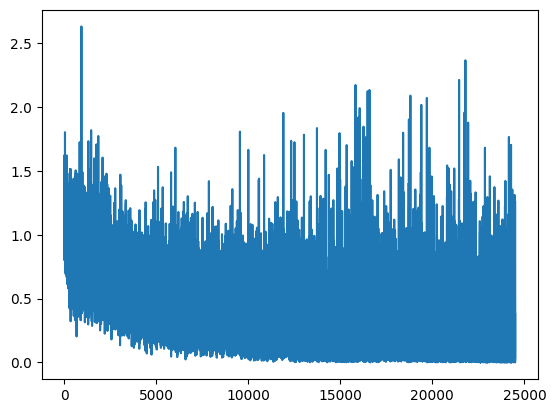

In [38]:
plt.plot(train_losses)

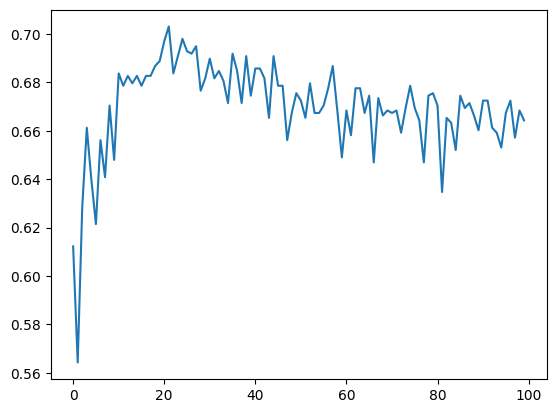

In [39]:
plt.plot(test_accuracy)

In [40]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=40, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m18mfcc40_best_22epoch.pt
Correct: 689/976 (0.7059)
{'acc_detail': tensor([0.7668, 0.6544, 0.7402, 0.6548], device='cuda:0'),
 'acc_unweighted': tensor(0.7040, device='cuda:0'),
 'acc_weighted': tensor(0.7059, device='cuda:0'),
 'f1s_detail': tensor([0.7729, 0.6499, 0.7520, 0.6433], device='cuda:0'),
 'f1s_unweighted': tensor(0.7045, device='cuda:0'),
 'f1s_weighted': tensor(0.7066, device='cuda:0'),
 'precision_detail': tensor([0.7791, 0.6455, 0.7642, 0.6322], device='cuda:0'),
 'recall_detail': tensor([0.7668, 0.6544, 0.7402, 0.6548], device='cuda:0'),
 'rocauc': tensor(0.8969, device='cuda:0'),
 'rocauc_detail': tensor([0.9297, 0.8878, 0.9305, 0.8397], device='cuda:0'),
 'uar': tensor(0.7040, device='cuda:0'),
 'wap': tensor(0.7076, device='cuda:0')}


tensor([[194,   9,   2,  48],
        [  6, 142,  45,  24],
        [  2,  40, 188,  24],
        [ 47,  29,  11, 165]], device='cuda:0')

In [41]:
# del model, best_model
# gc.collect()

643